In [19]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer, QuantumCircuit, transpile, Aer, IBMQ
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
from skimage.transform import resize
#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    #for i in range(2,20):
     #   assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(255*image1,255*image2)

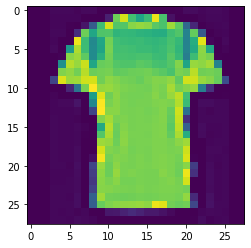

In [11]:
data_path='data'
#load the actual hackthon data (fashion-mnist)
images=np.load(data_path+'/images.npy')
labels=np.load(data_path+'/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1])

In [21]:
#submission to part 1, you should make this into a .py file

n=len(images)
mse=0
gatecount=0

# Functions 'encode' and 'decode' are dummy.
def encode(image):
 #   q = qiskit.QuantumRegister(3)
  #  circuit = qiskit.QuantumCircuit(q)
    image_og =  image
    image = resize(image_og, (32, 32))
    #Convert the raw pixel values to probability amplitudes
    def amplitude_encode(img_data):

        # Calculate the RMS value
        rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

        # Create normalized image
        image_norm = []
        for arr in img_data:
            for ele in arr:
                image_norm.append(ele / rms)

        # Return the normalized image as a numpy array
        return np.array(image_norm)

    # Get the amplitude ancoded pixel values
    # Horizontal: Original image
    image_norm_h = amplitude_encode(image)
    print(image_norm_h)

    # Vertical: Transpose of Original image
    image_norm_v = amplitude_encode(image.T)
    
    data_qb = 10
    anc_qb = 1
    total_qb = data_qb + anc_qb

    # Initialize the amplitude permutation unitary
    D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
    
    # Create the circuit for horizontal scan
    qc_h = QuantumCircuit(total_qb)
    qc_h.initialize(image_norm_h, range(1, total_qb))
    qc_h.h(0)
    qc_h.unitary(D2n_1, range(total_qb))
    qc_h.h(0)
    display(qc_h.draw(output="mpl",fold=-1))

    # Create the circuit for vertical scan
    qc_v = QuantumCircuit(total_qb)
    qc_v.initialize(image_norm_v, range(1, total_qb))
    qc_v.h(0)
    qc_v.unitary(D2n_1, range(total_qb))
    qc_v.h(0)
    display(qc_v.draw(output='mpl', fold=-1))

    # Combine both circuits into a single list
    circ_list = [qc_h, qc_v]
    #return circ_list
    return qc_v

def decode(histogram):
    # Get the measurement counts from the result
    data_qb = 10
    sim_keys_h = histogram.keys()
    sim_keys_v = histogram.keys()

    # Filter and extract the counts for odd-numbered states
    # and make the full edge-detected image by adding horizontal and vertical scans
    edge_scan_sim_h = np.array([sim_counts_h[f'{2*i+1:03b}'] if f'{2*i+1:03b}' in sim_keys_h else 0 for i in range(2**data_qb)]).reshape(32, 32)
    edge_scan_sim_v = np.array([sim_counts_v[f'{2*i+1:03b}'] if f'{2*i+1:03b}' in sim_keys_v else 0 for i in range(2**data_qb)]).reshape(32, 32).T
    edge_detected_sim_small = edge_scan_sim_h + edge_scan_sim_v
    image = resize(edge_detected_sim_small, (28, 28))
    
    return image

def run_part1(image):
    #encode image into a circuit
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re

[0. 0. 0. ... 0. 0. 0.]


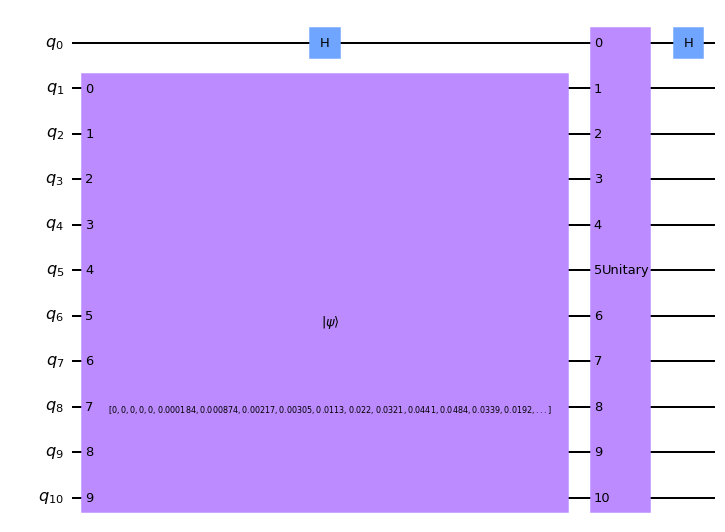

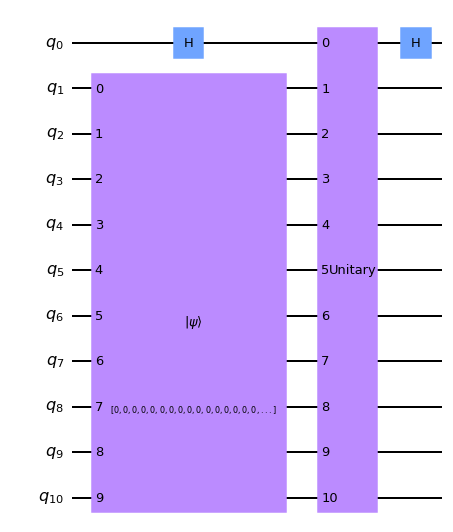

[0.         0.         0.         ... 0.00081335 0.         0.        ]


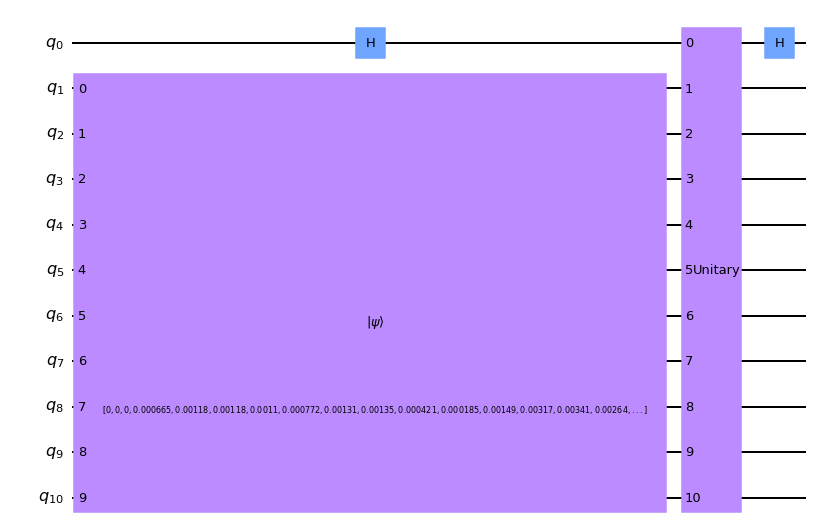

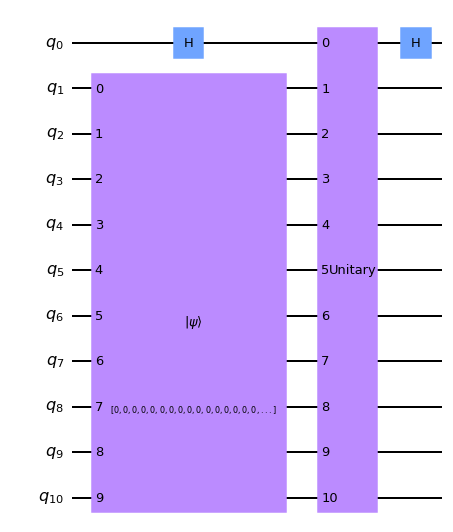

[0. 0. 0. ... 0. 0. 0.]


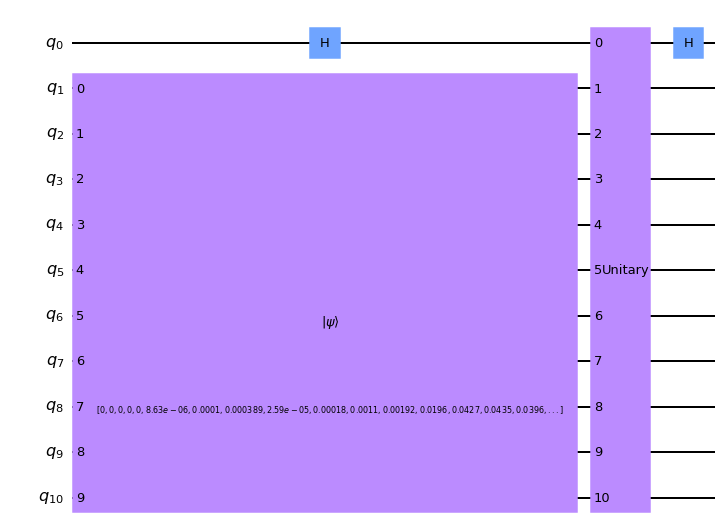

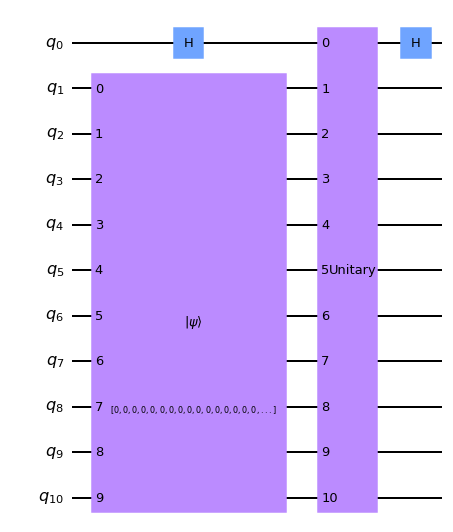

[0. 0. 0. ... 0. 0. 0.]


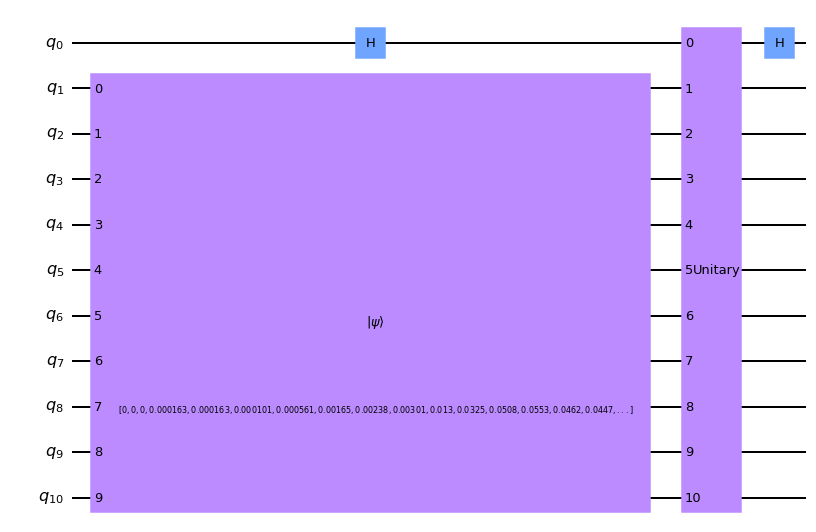

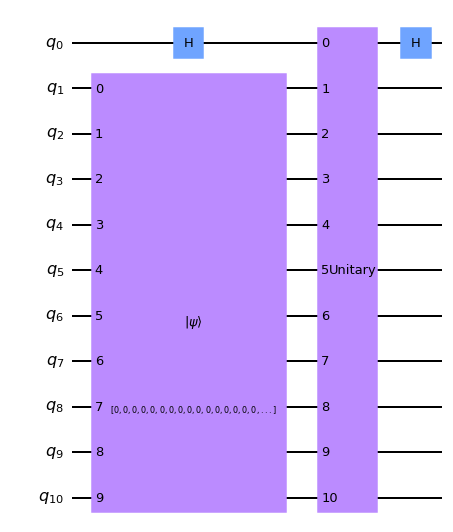

[0. 0. 0. ... 0. 0. 0.]


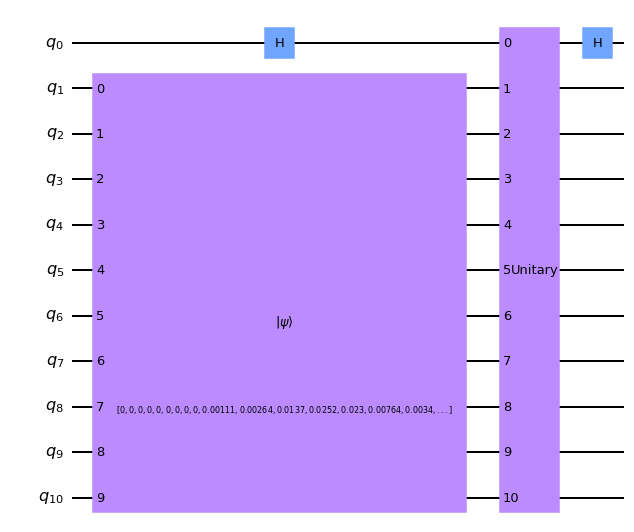

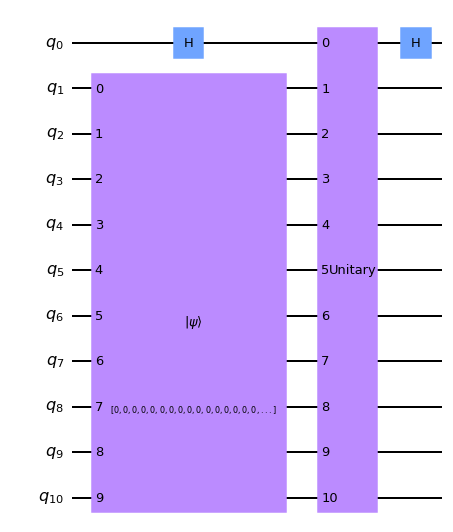

[0. 0. 0. ... 0. 0. 0.]


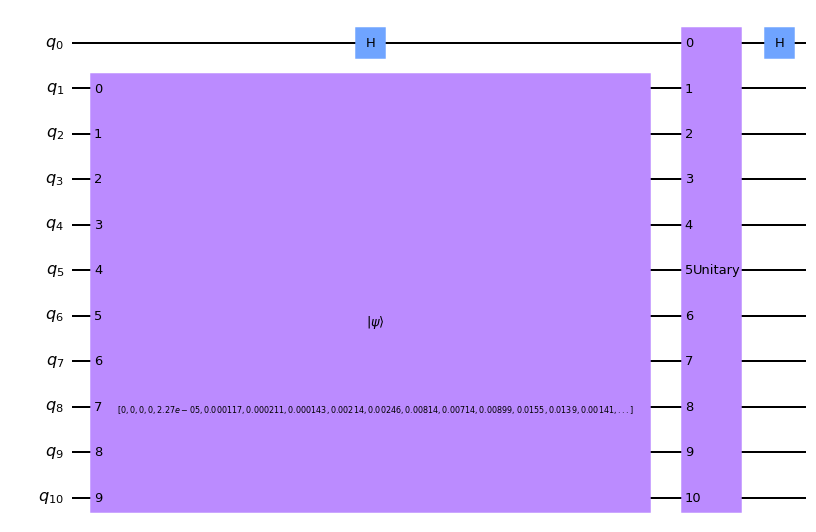

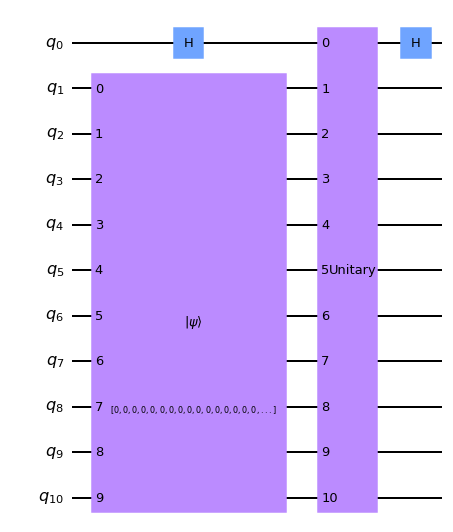

[0. 0. 0. ... 0. 0. 0.]


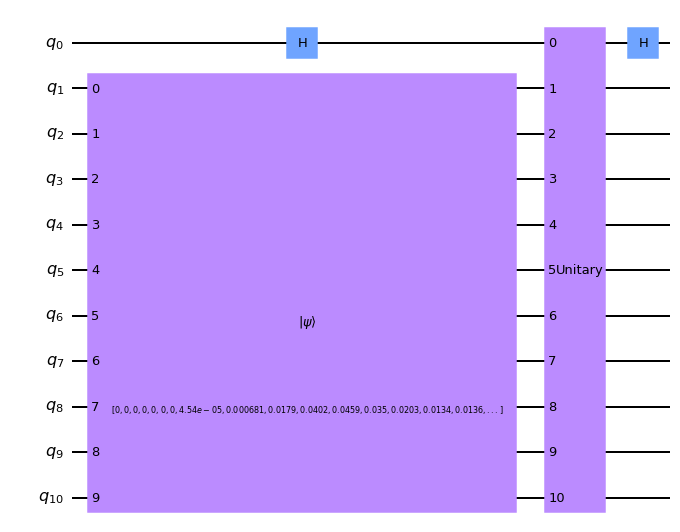

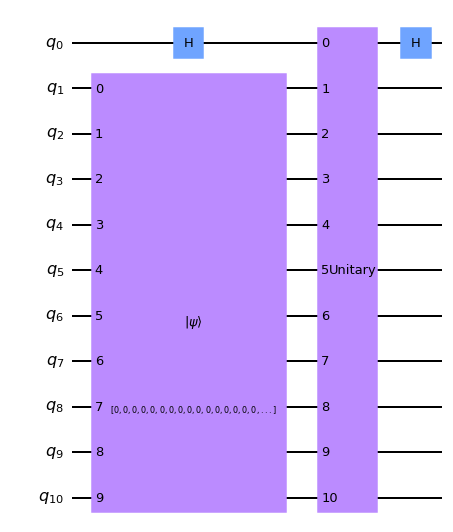

[0. 0. 0. ... 0. 0. 0.]


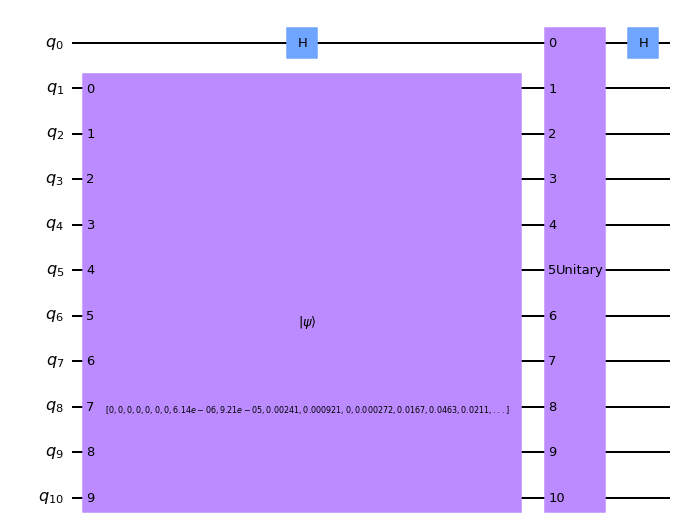

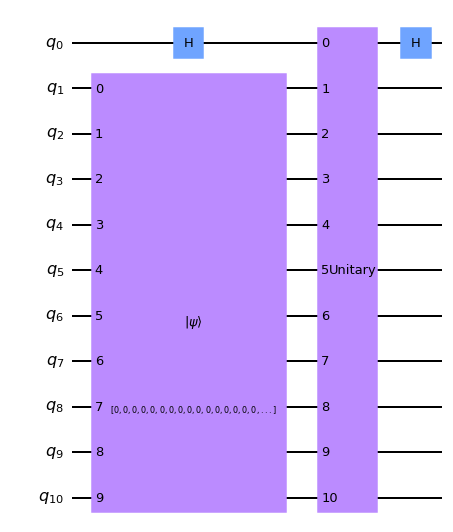

[0. 0. 0. ... 0. 0. 0.]


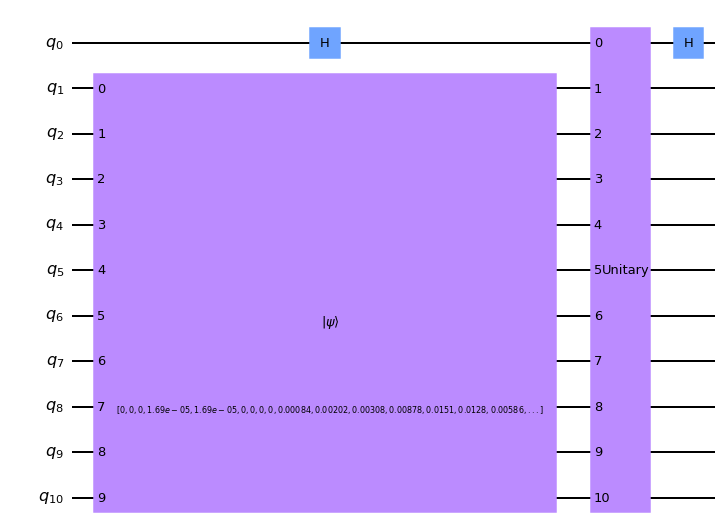

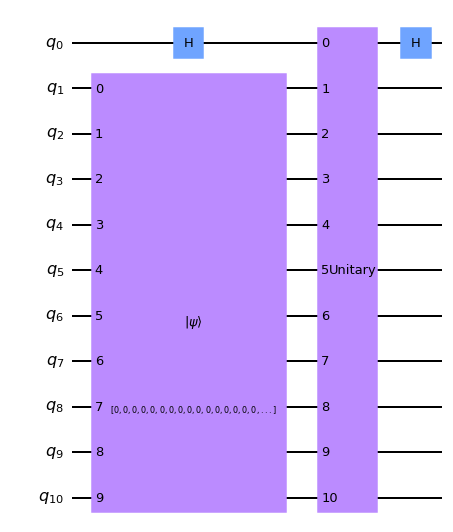

[0. 0. 0. ... 0. 0. 0.]


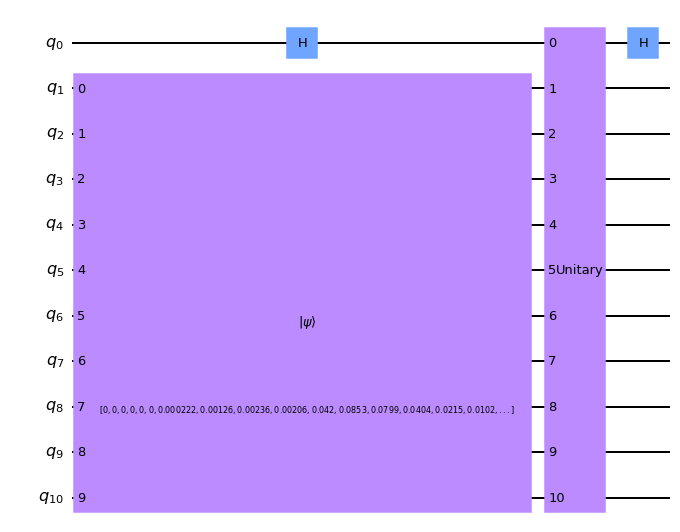

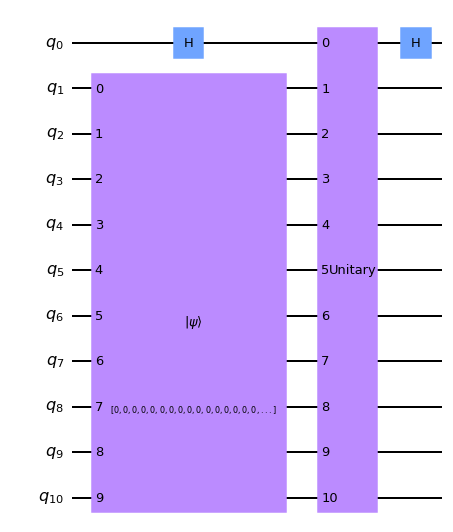

[0. 0. 0. ... 0. 0. 0.]


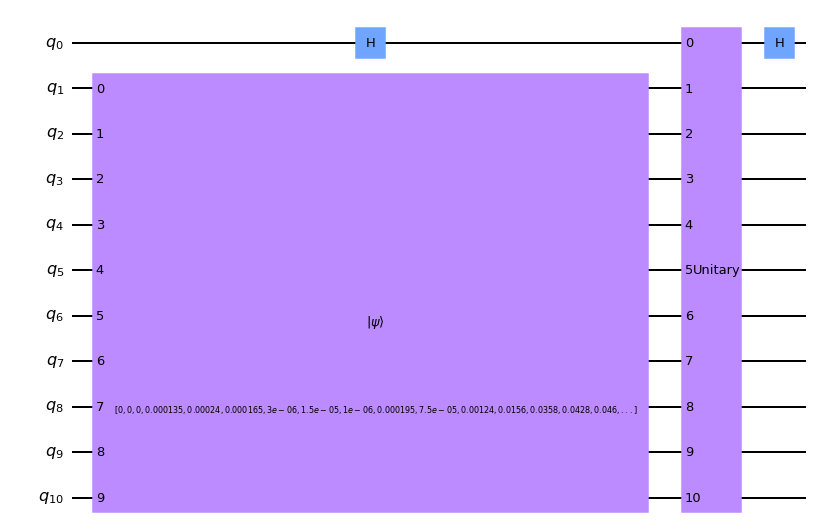

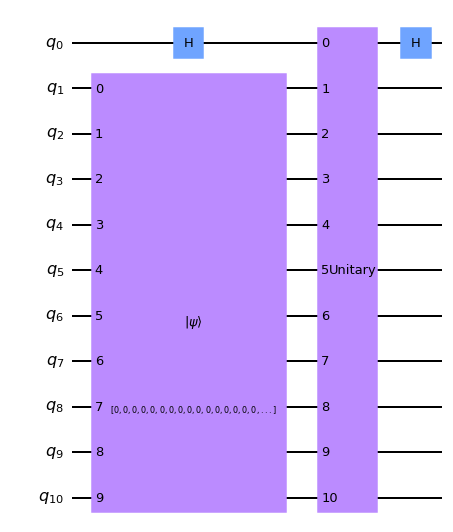

[0. 0. 0. ... 0. 0. 0.]


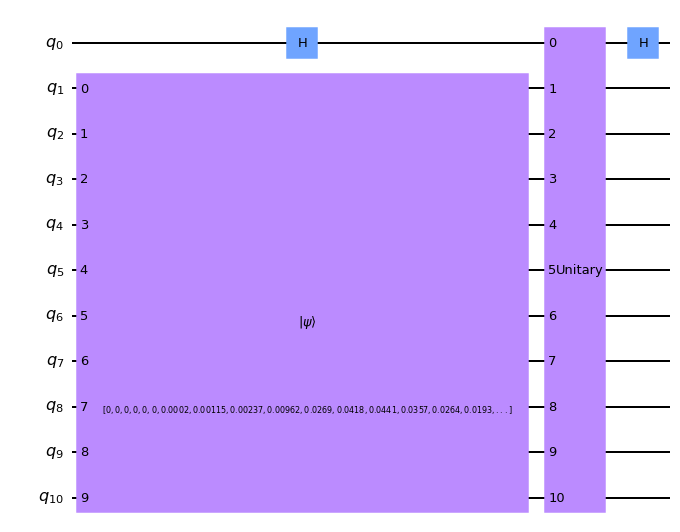

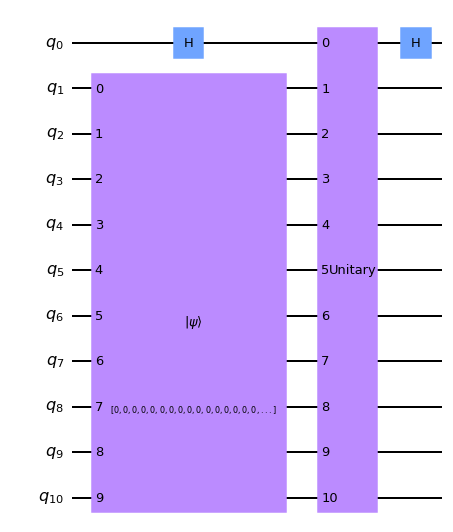

[0. 0. 0. ... 0. 0. 0.]


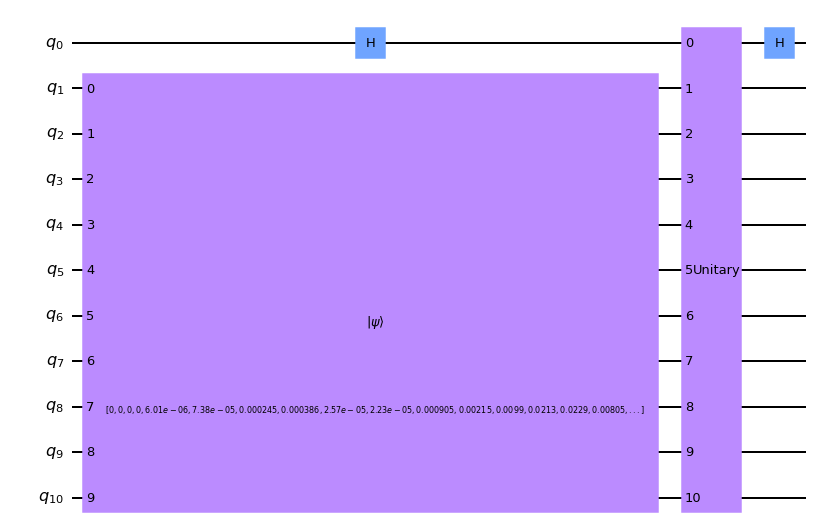

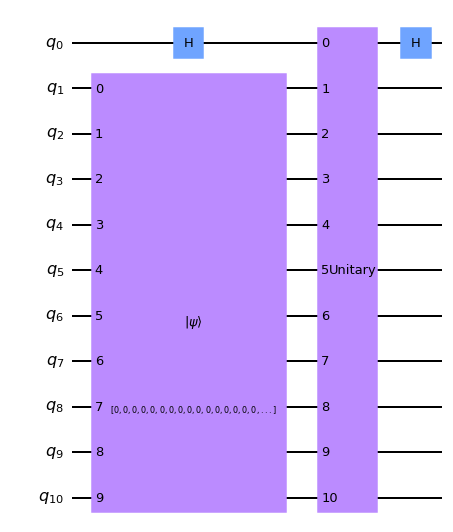

[0. 0. 0. ... 0. 0. 0.]


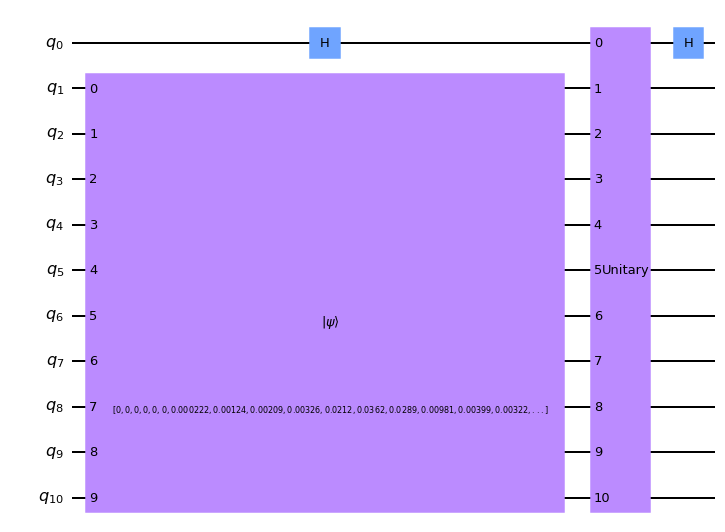

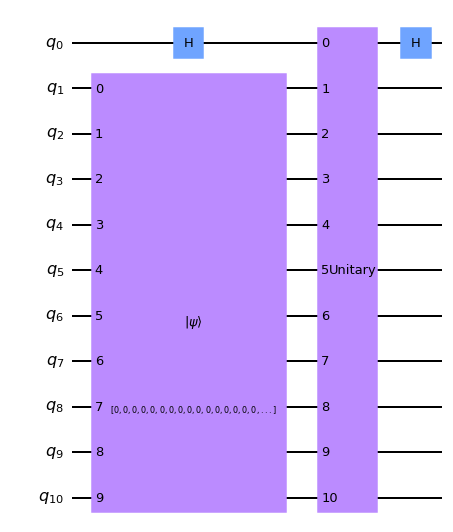

[0. 0. 0. ... 0. 0. 0.]


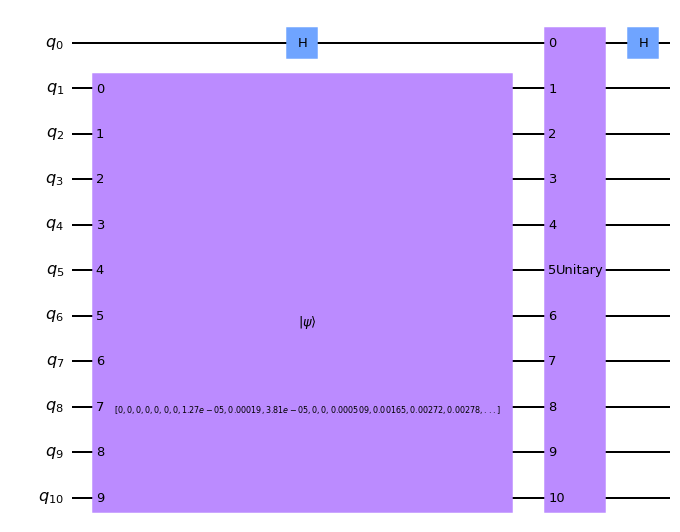

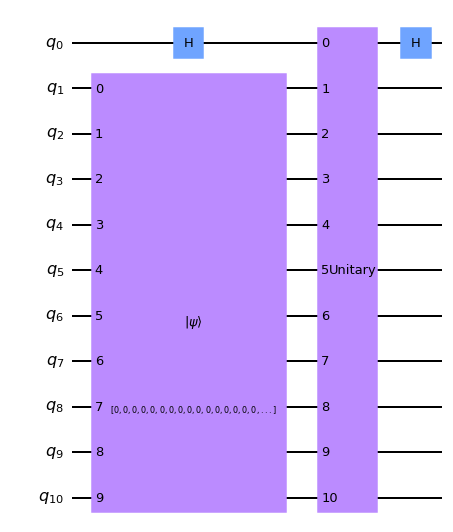

[0. 0. 0. ... 0. 0. 0.]


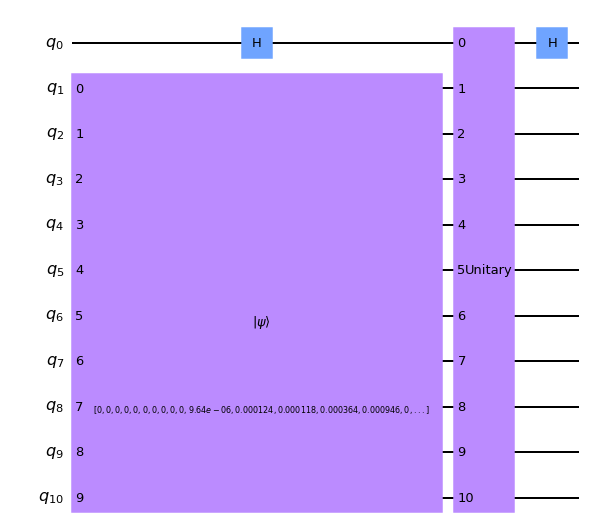

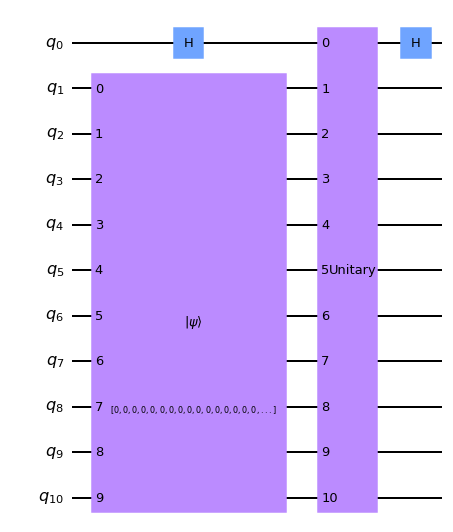

[0. 0. 0. ... 0. 0. 0.]


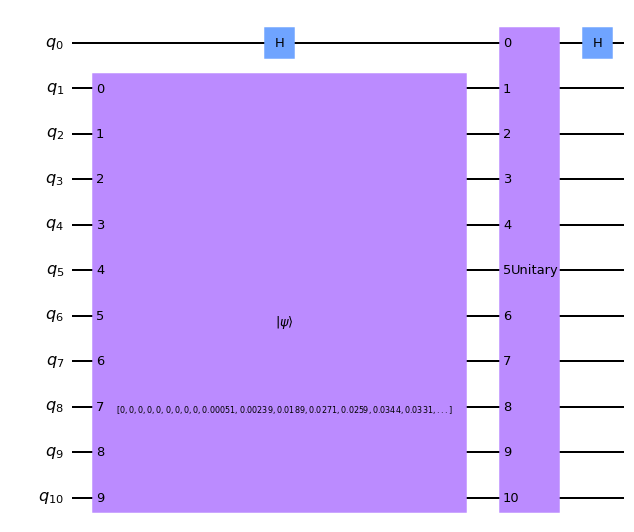

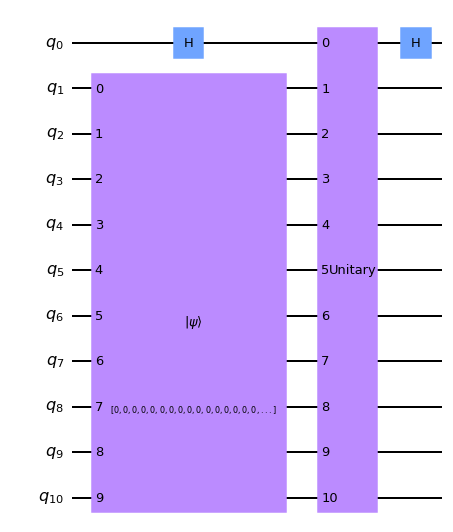

[0.00000000e+00 0.00000000e+00 1.00907667e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


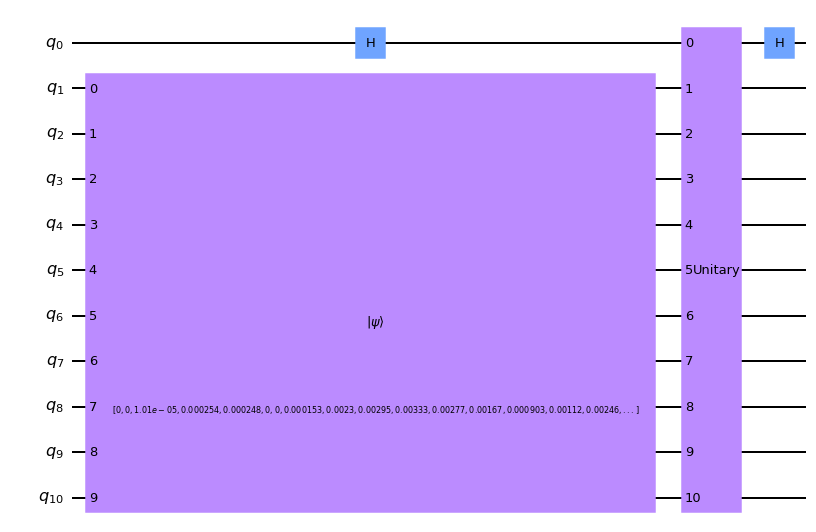

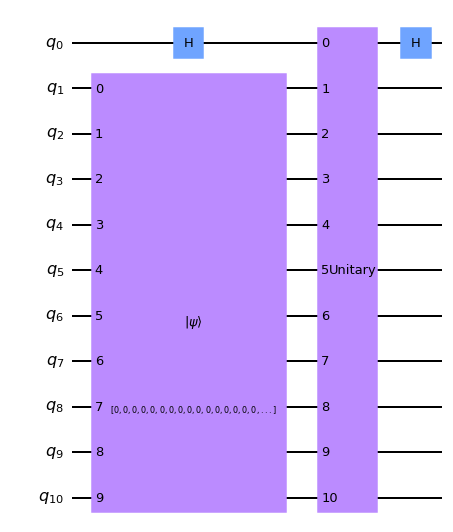

[0.         0.         0.00014888 ... 0.         0.         0.        ]


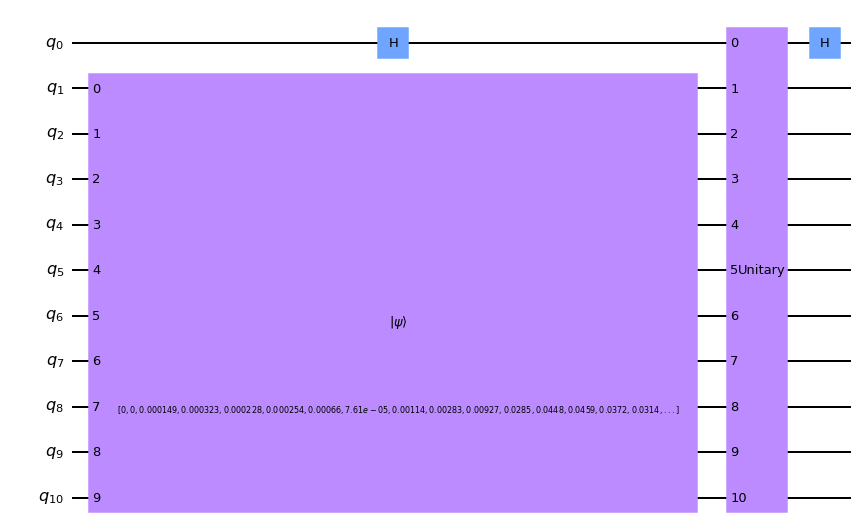

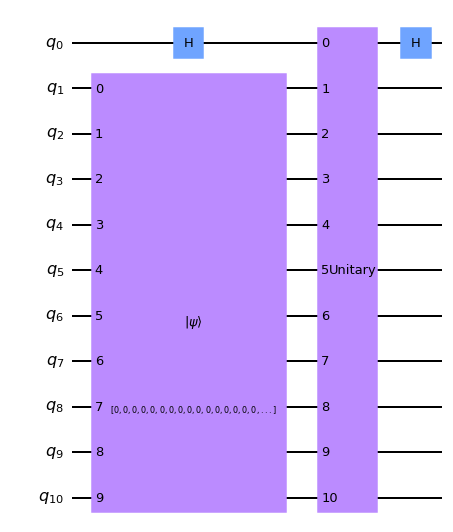

[0. 0. 0. ... 0. 0. 0.]


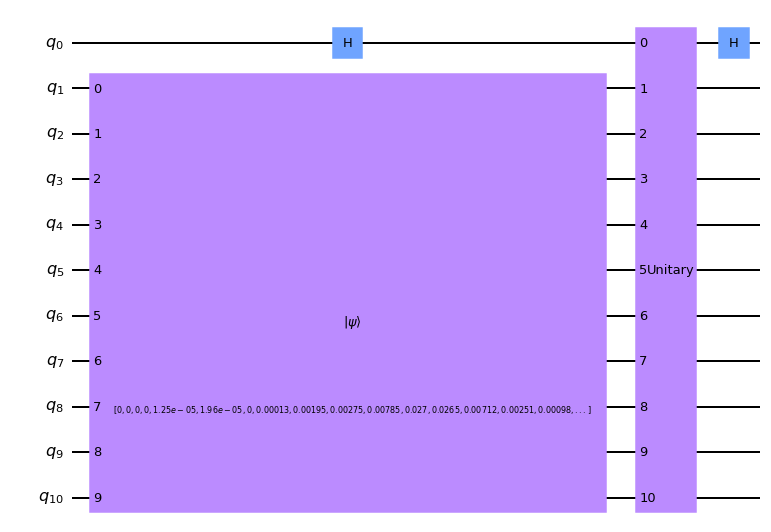

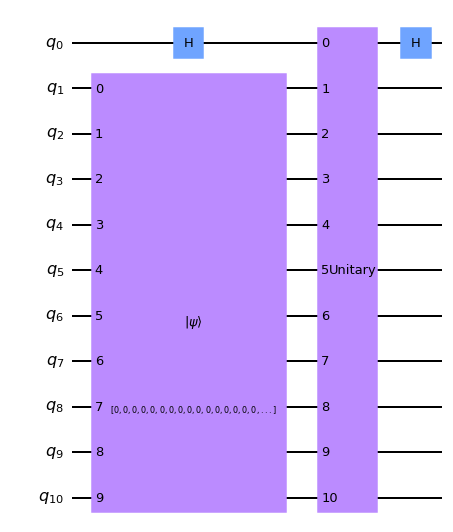

[0. 0. 0. ... 0. 0. 0.]


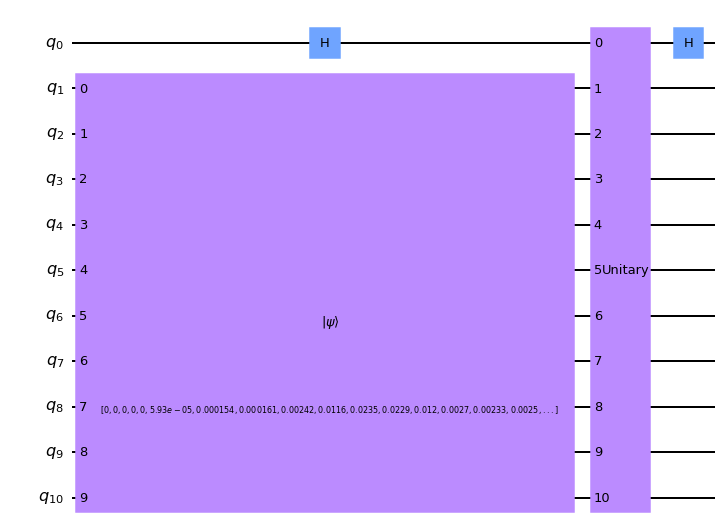

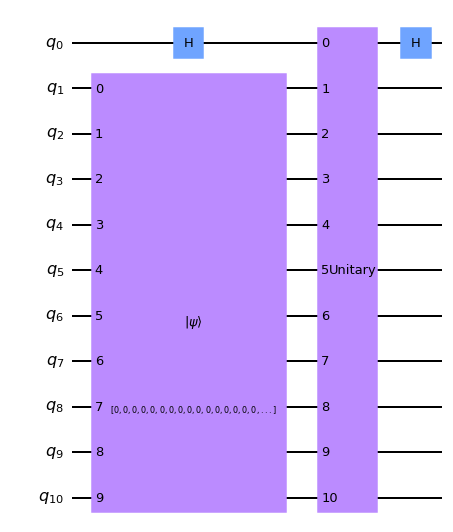

[0. 0. 0. ... 0. 0. 0.]


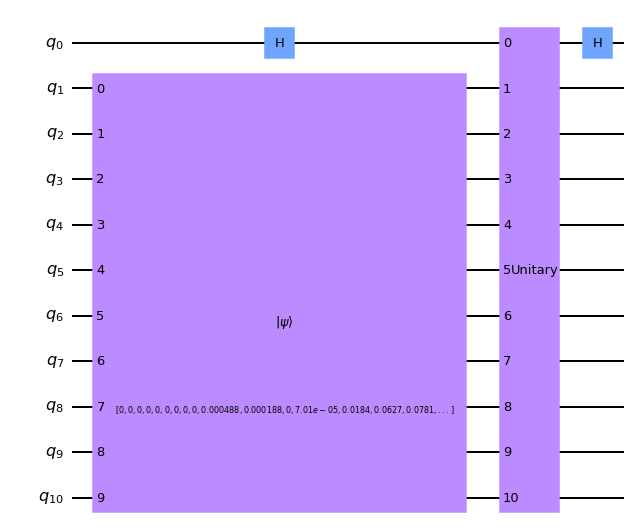

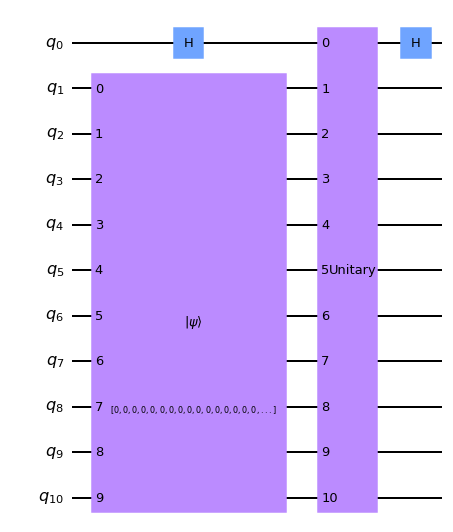

[0. 0. 0. ... 0. 0. 0.]


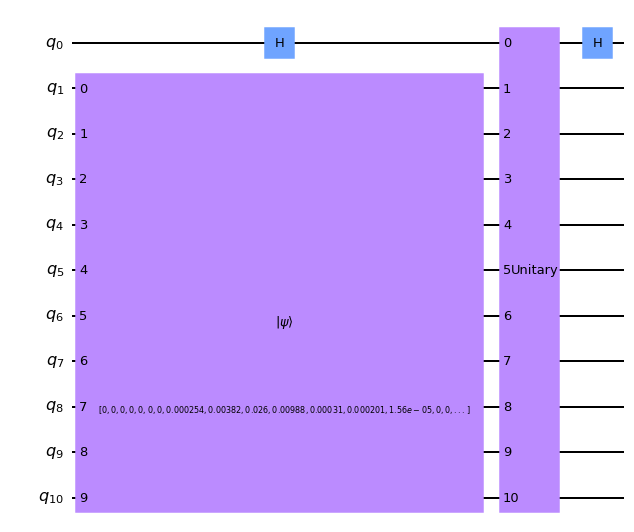

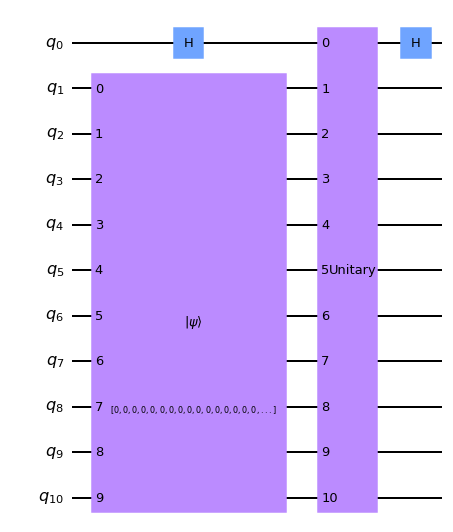

[0. 0. 0. ... 0. 0. 0.]


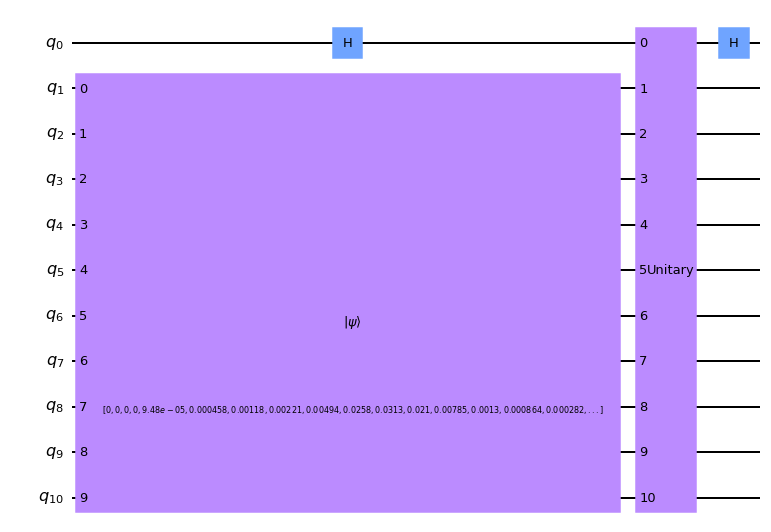

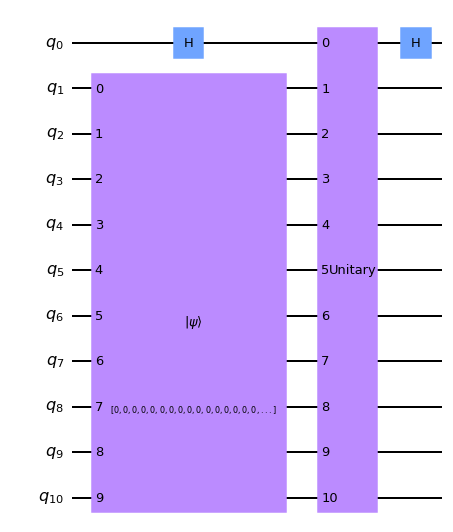

[0.         0.         0.         ... 0.00024235 0.         0.        ]


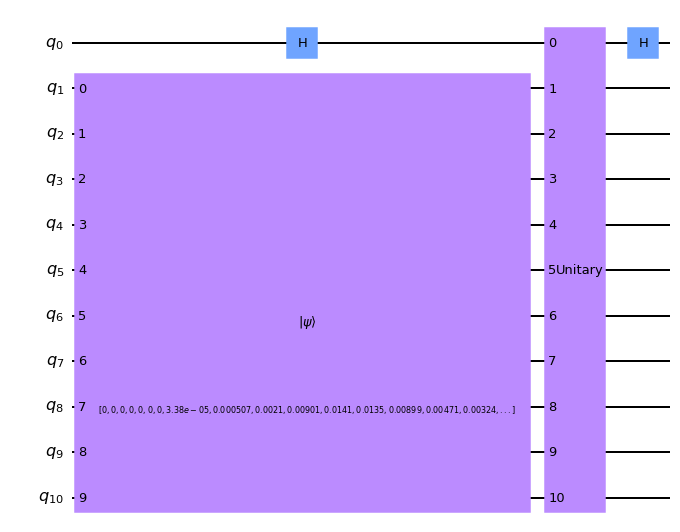

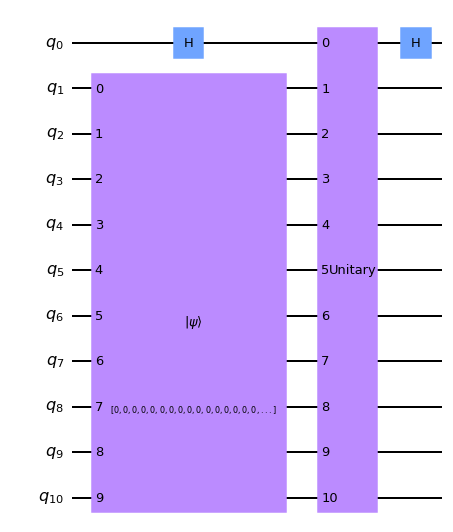

[0. 0. 0. ... 0. 0. 0.]


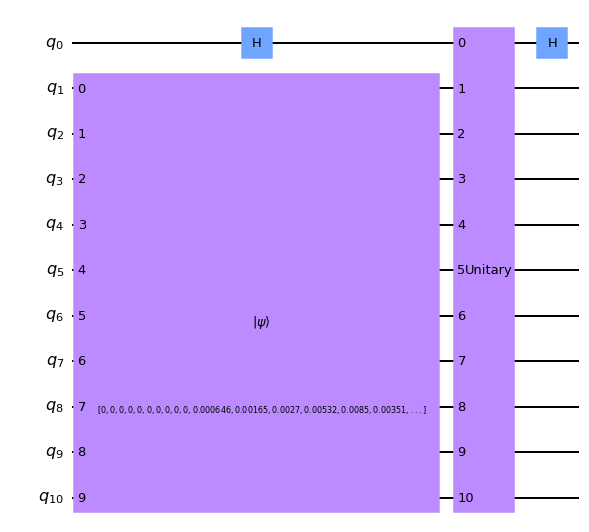

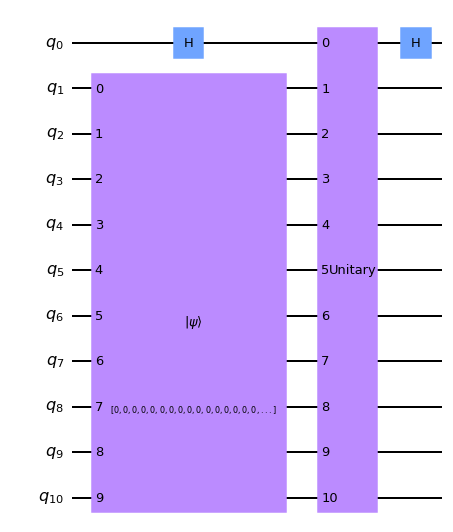

[0. 0. 0. ... 0. 0. 0.]


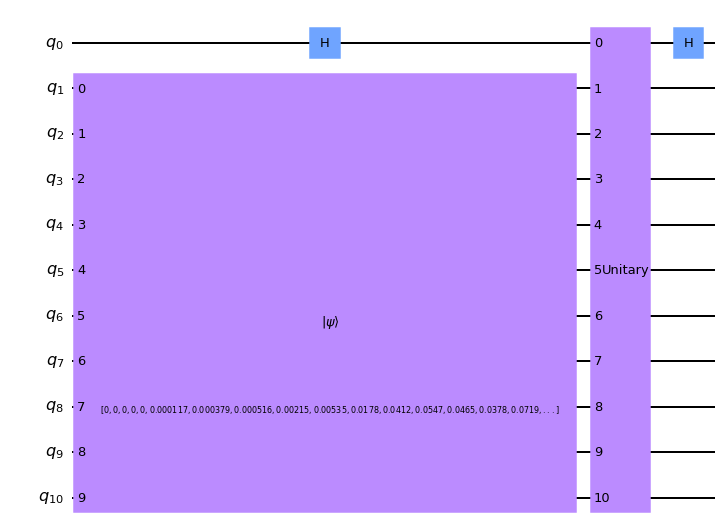

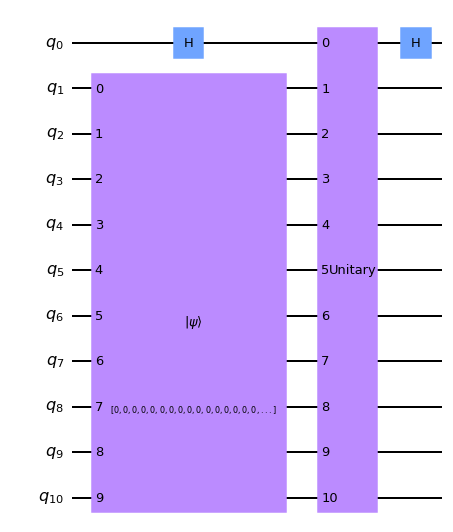

[0. 0. 0. ... 0. 0. 0.]


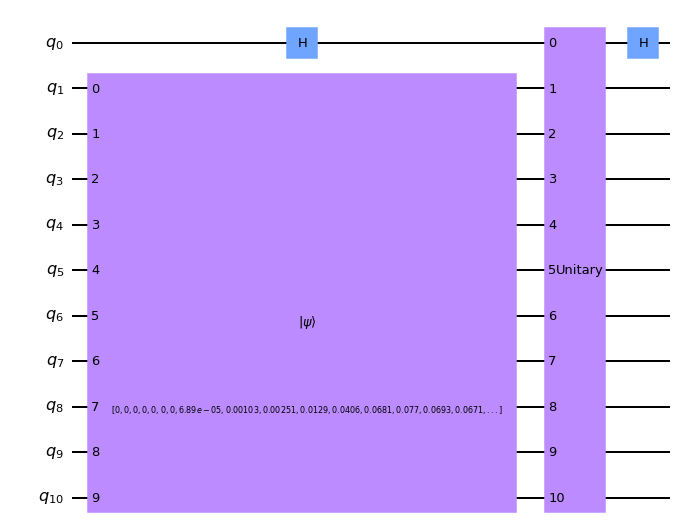

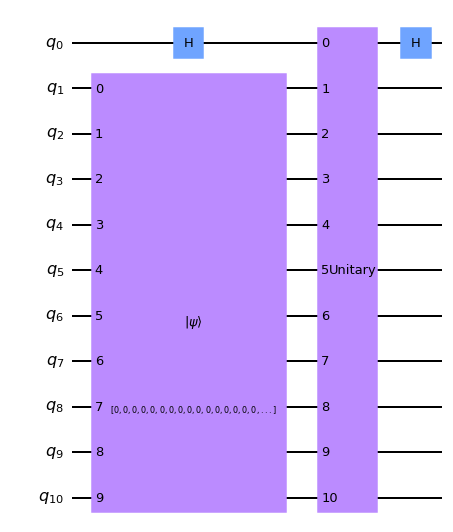

[0. 0. 0. ... 0. 0. 0.]


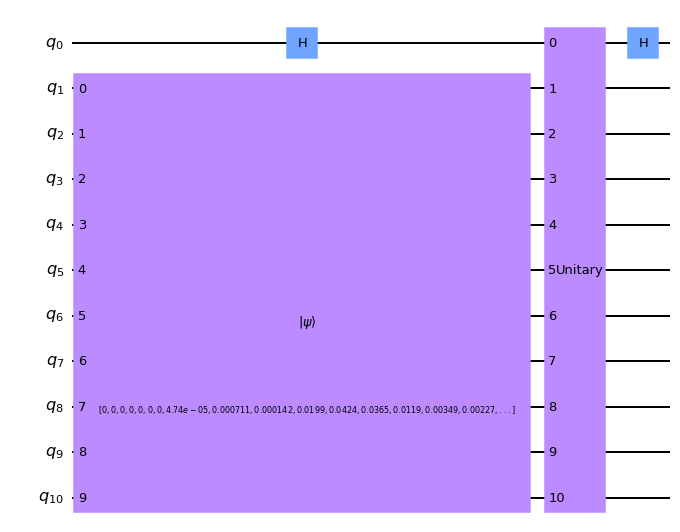

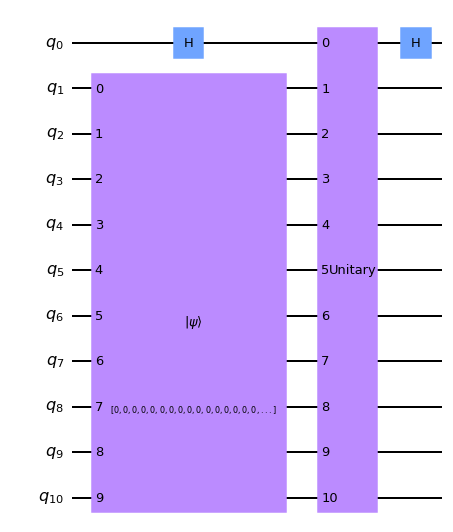

[0. 0. 0. ... 0. 0. 0.]


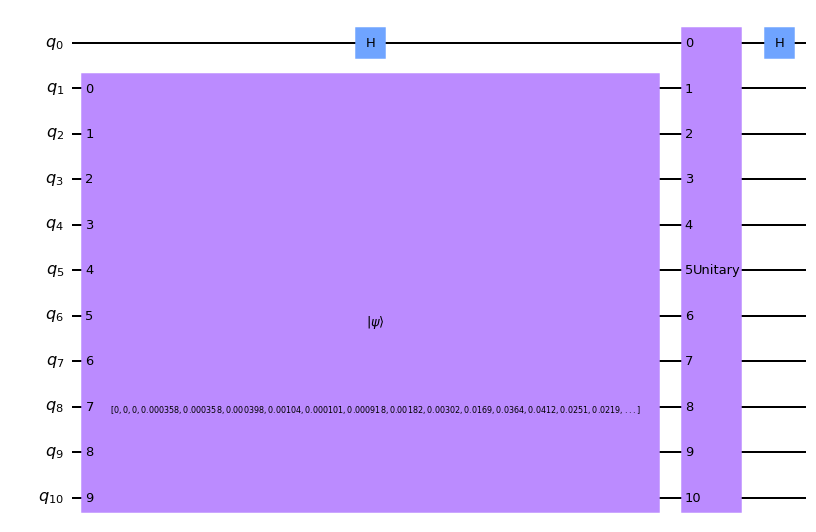

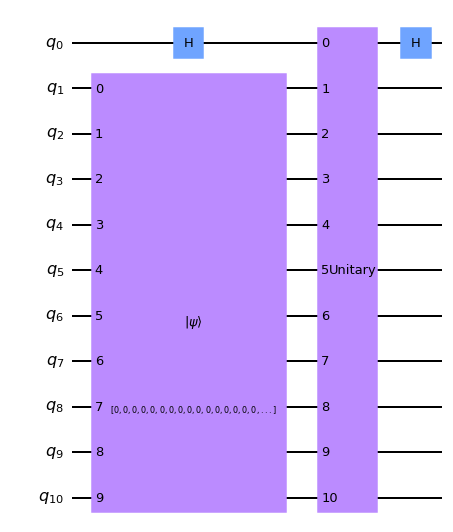

[0.         0.         0.00038071 ... 0.         0.         0.        ]


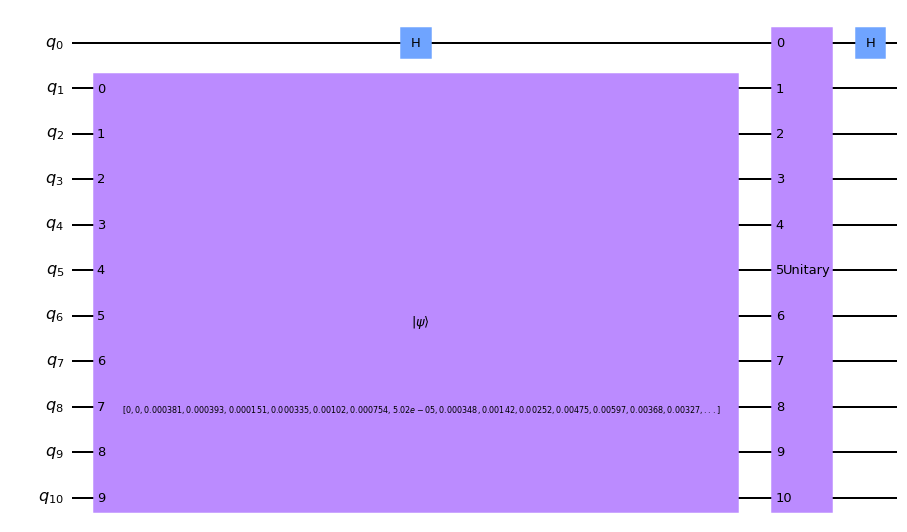

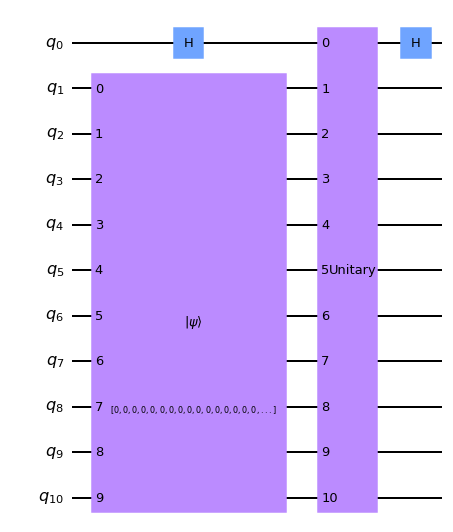

[0.         0.         0.00016148 ... 0.         0.         0.        ]


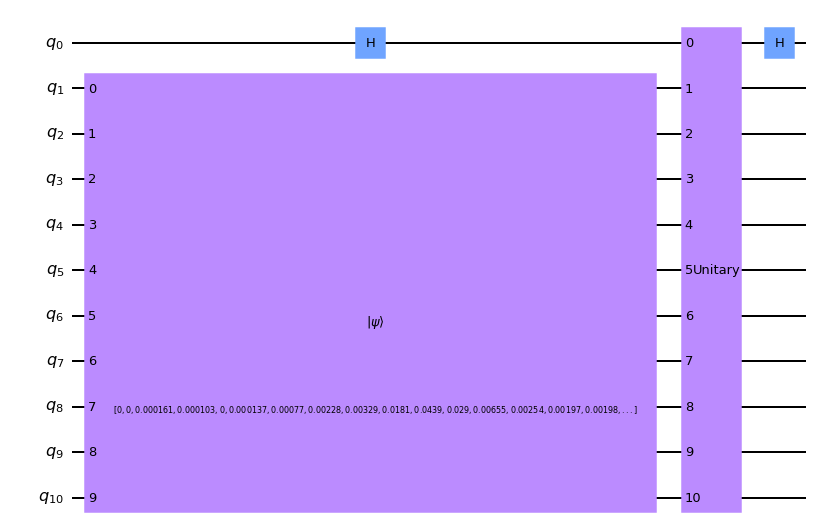

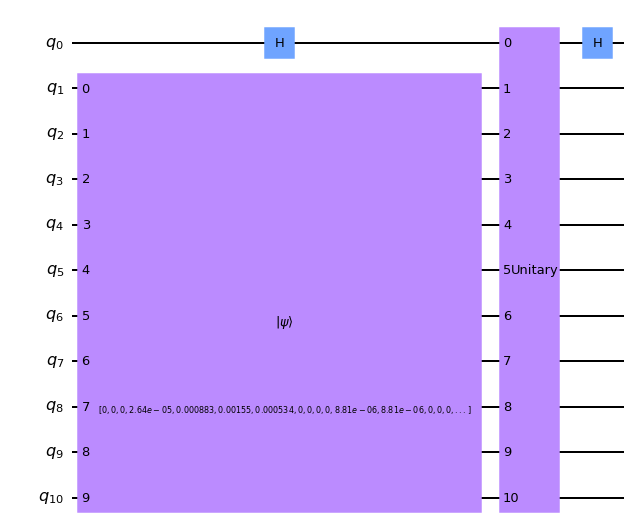

[0.         0.         0.         ... 0.00017074 0.         0.        ]


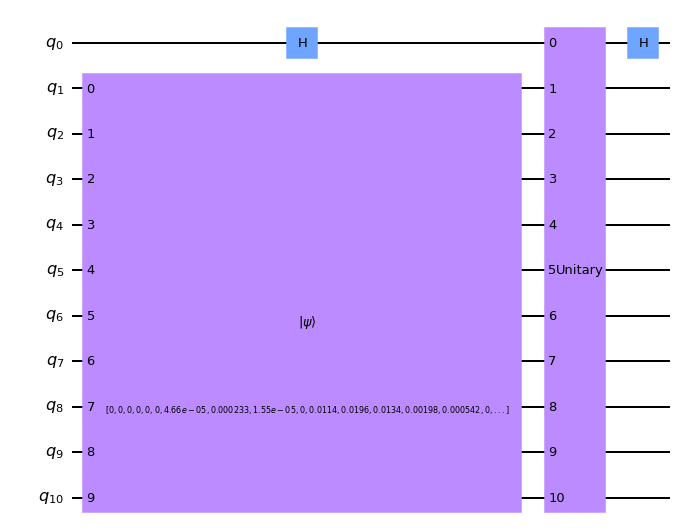

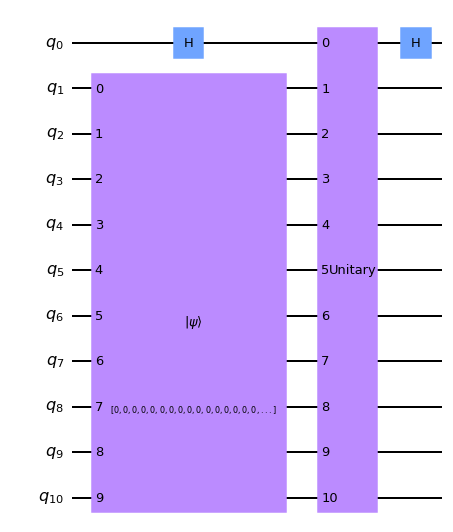

[0. 0. 0. ... 0. 0. 0.]


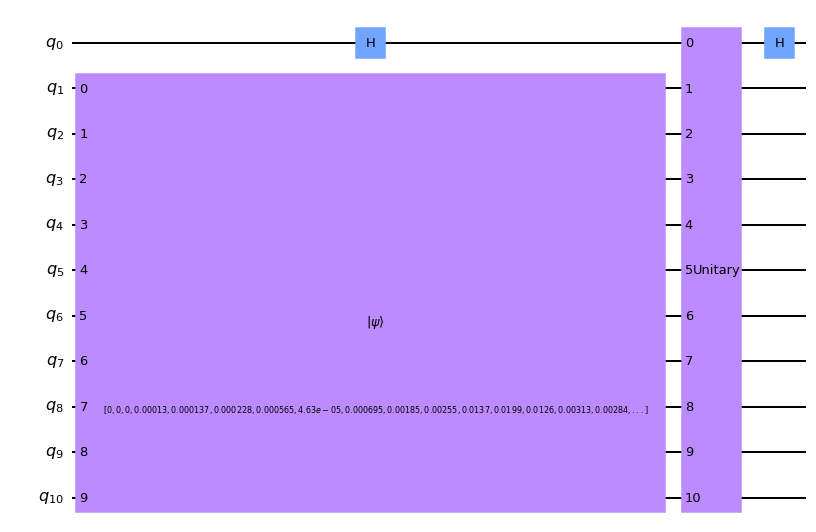

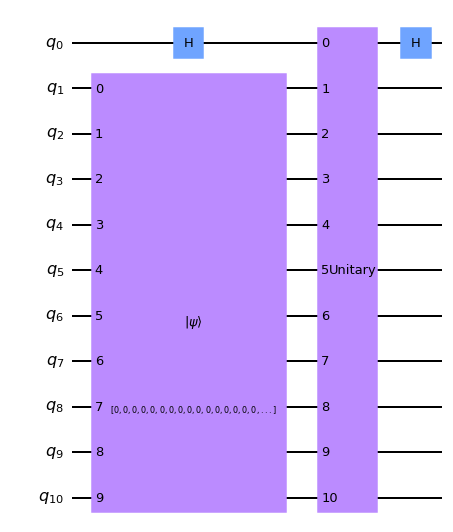

[0. 0. 0. ... 0. 0. 0.]


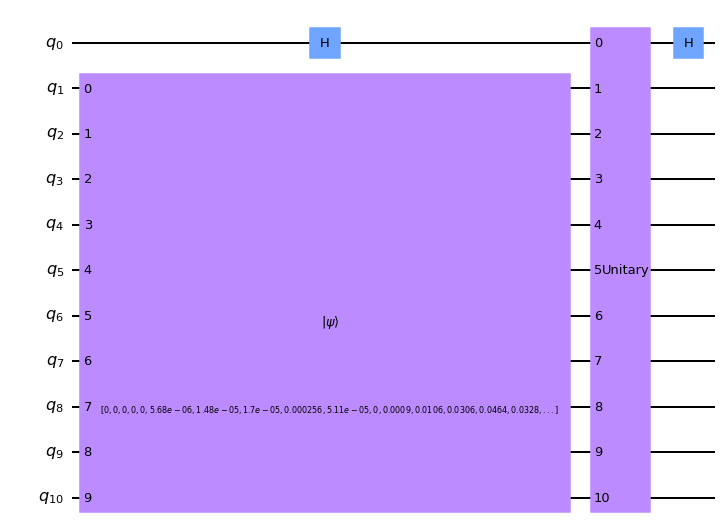

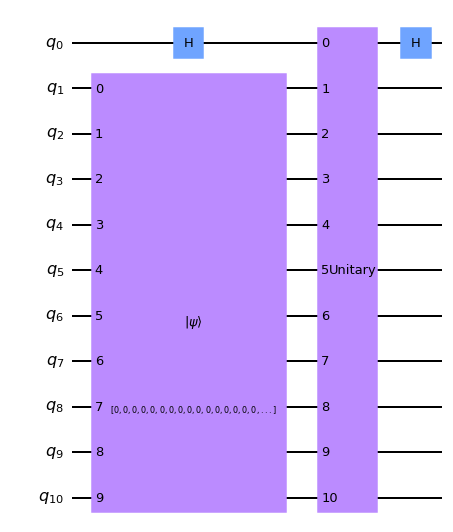

[0. 0. 0. ... 0. 0. 0.]


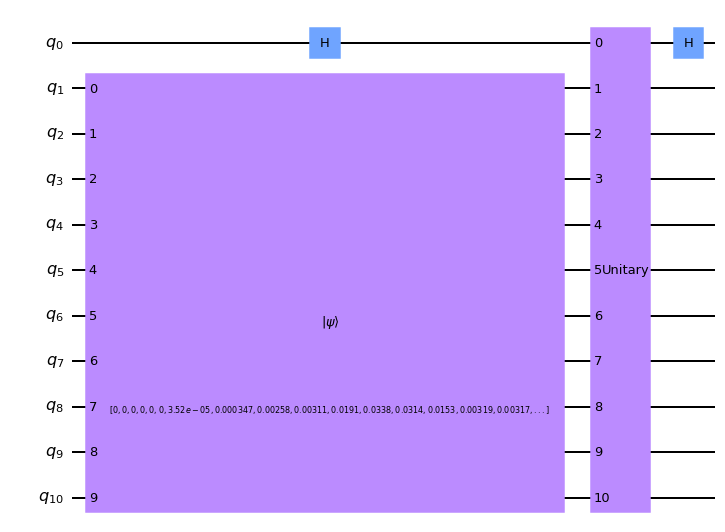

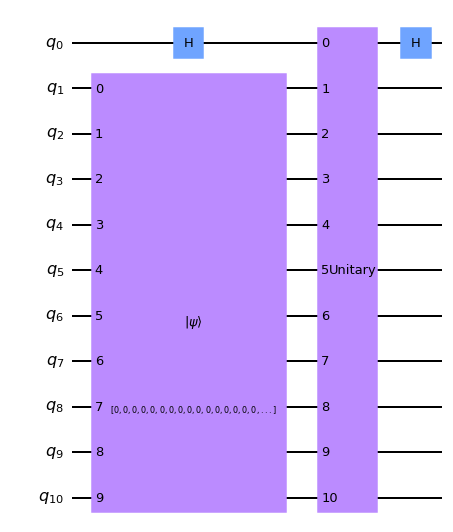

[0. 0. 0. ... 0. 0. 0.]


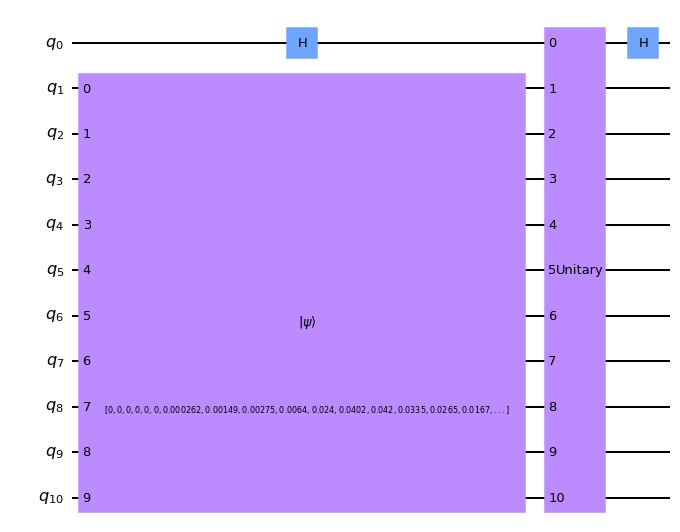

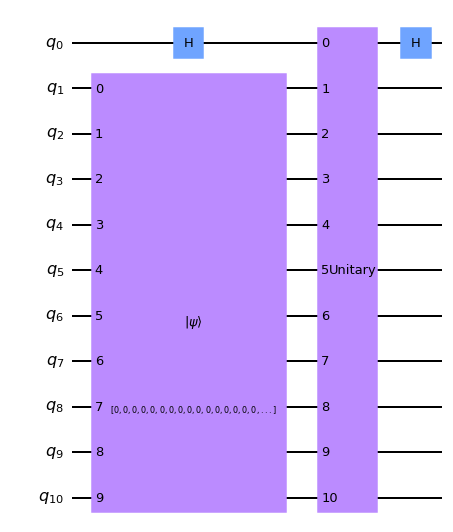

[0. 0. 0. ... 0. 0. 0.]


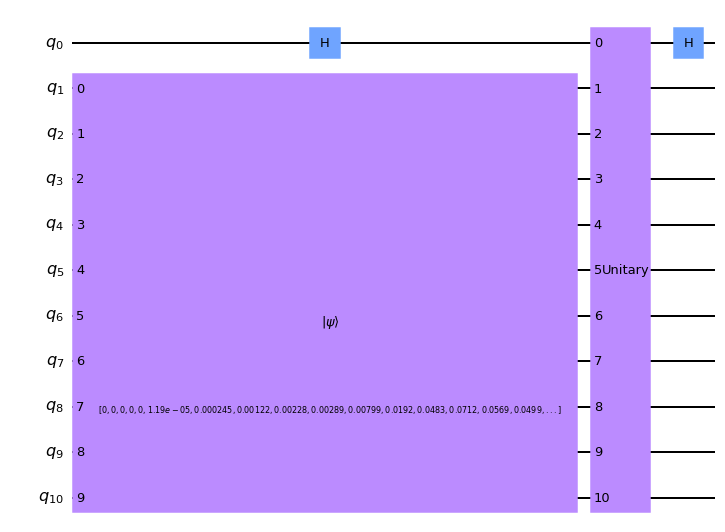

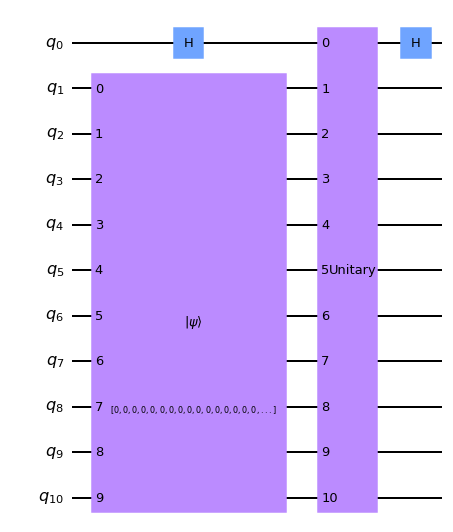

[0. 0. 0. ... 0. 0. 0.]


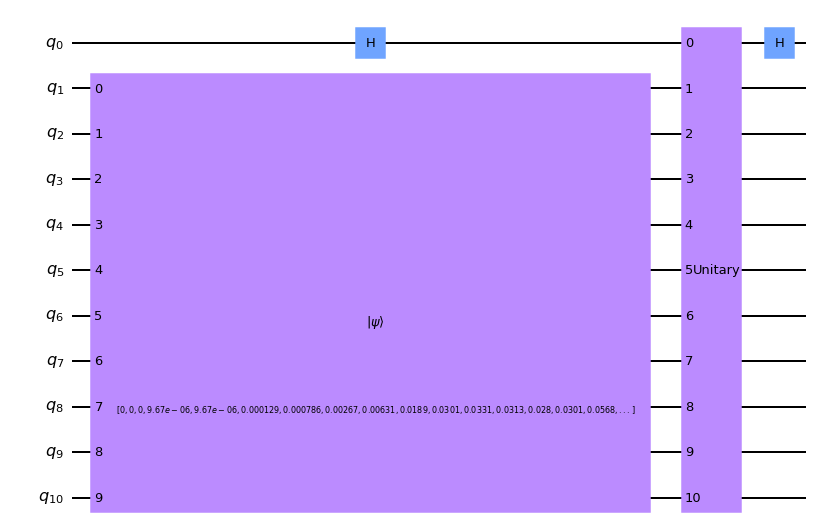

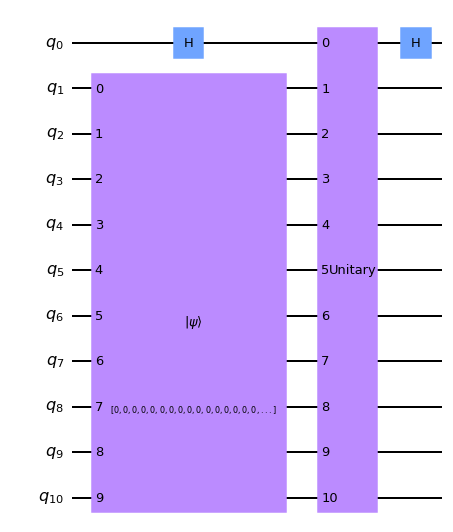

[0. 0. 0. ... 0. 0. 0.]


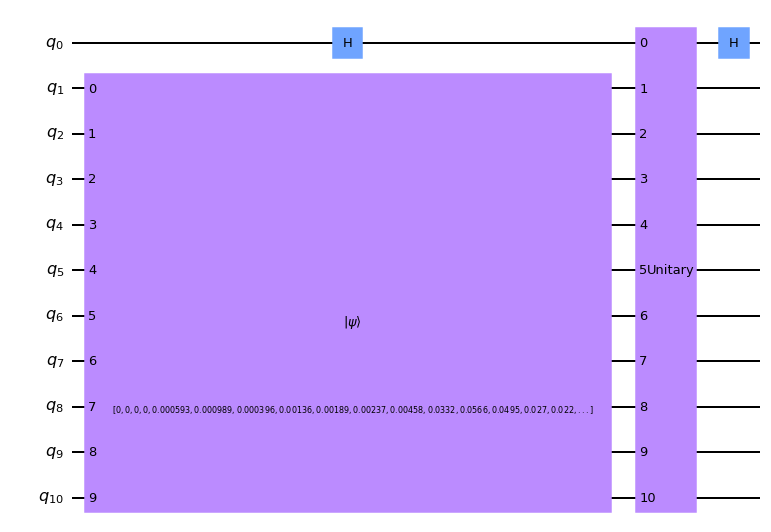

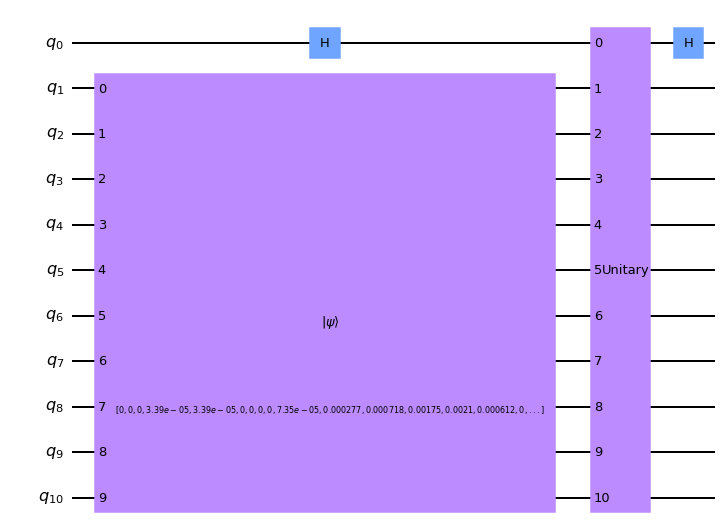

[0. 0. 0. ... 0. 0. 0.]


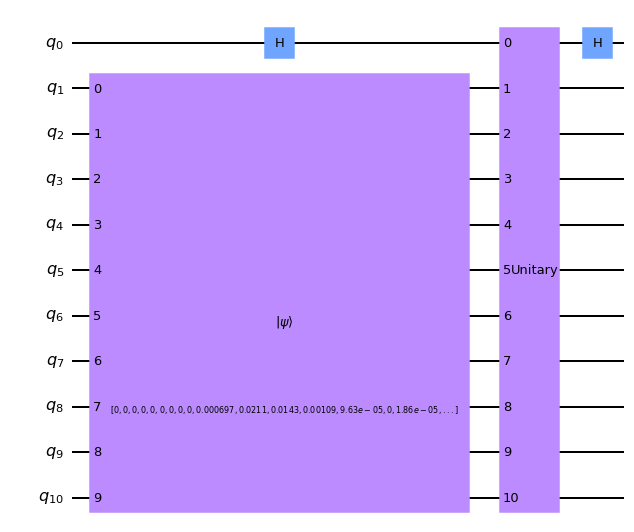

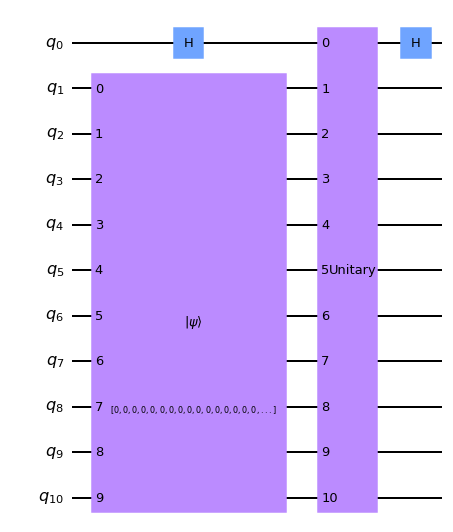

[0. 0. 0. ... 0. 0. 0.]


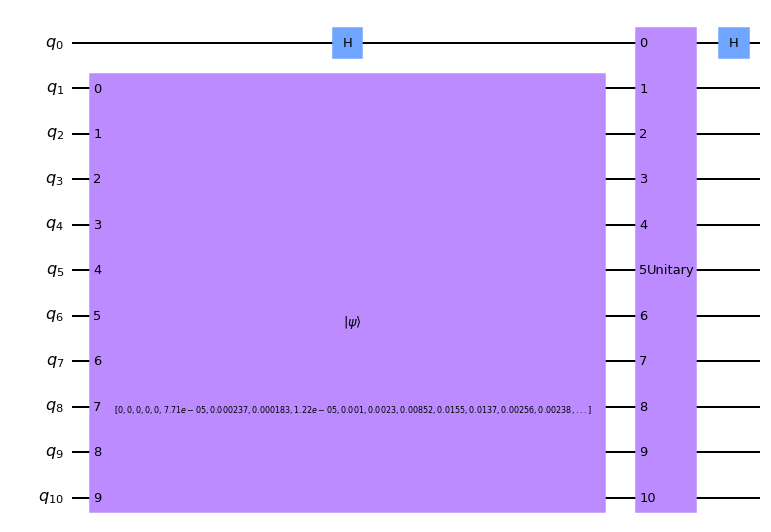

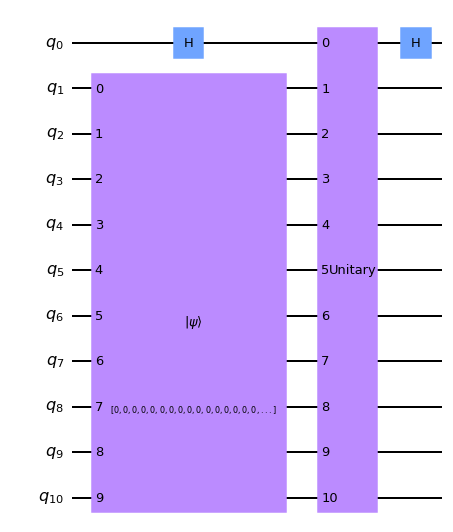

[0. 0. 0. ... 0. 0. 0.]


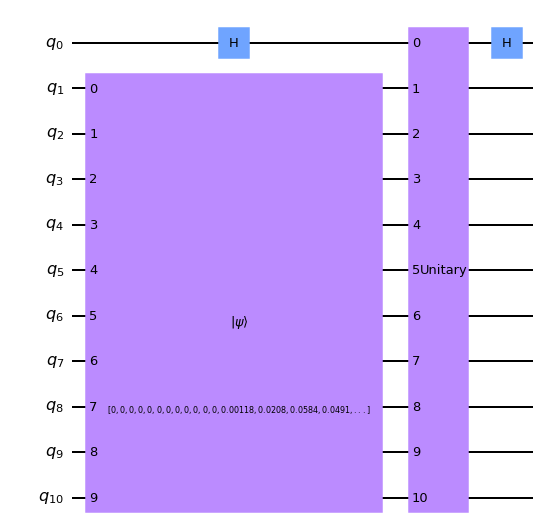

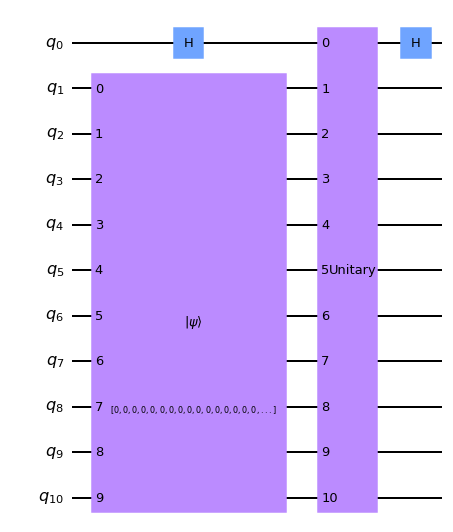

[1.74843621e-05 2.27296707e-04 9.94423094e-05 ... 1.92327983e-04
 0.00000000e+00 0.00000000e+00]


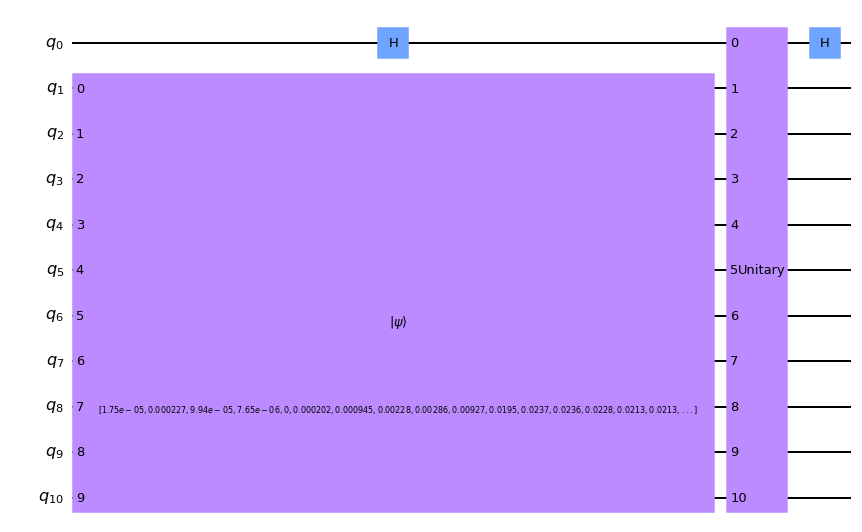

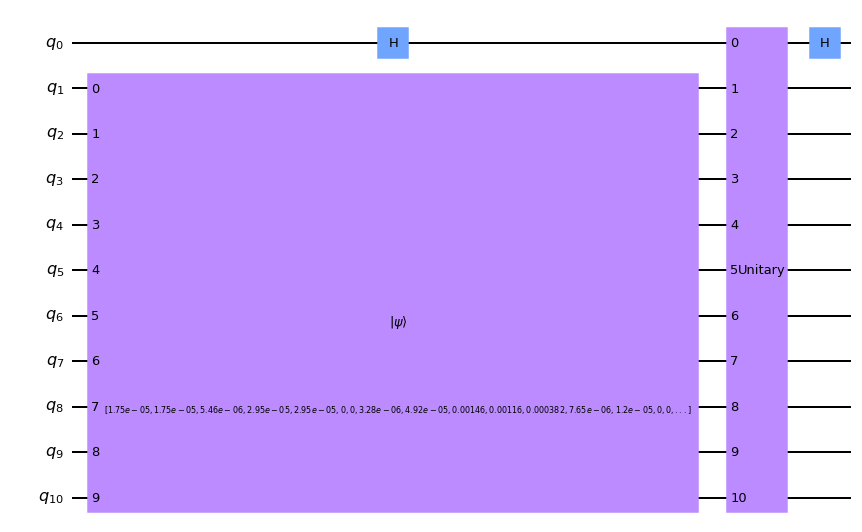

[0. 0. 0. ... 0. 0. 0.]


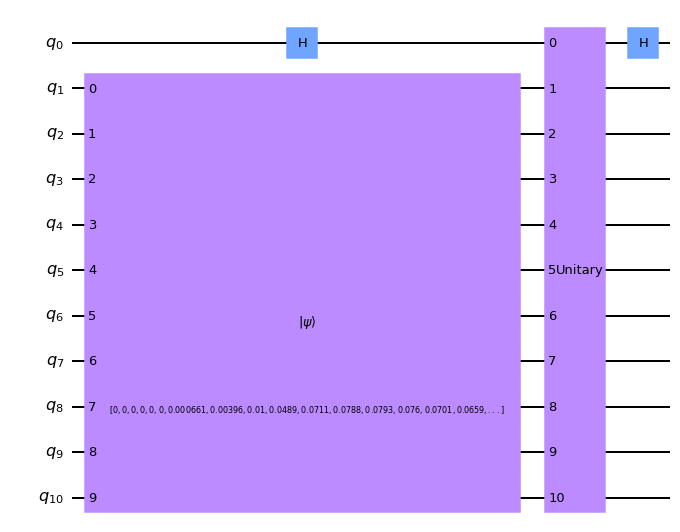

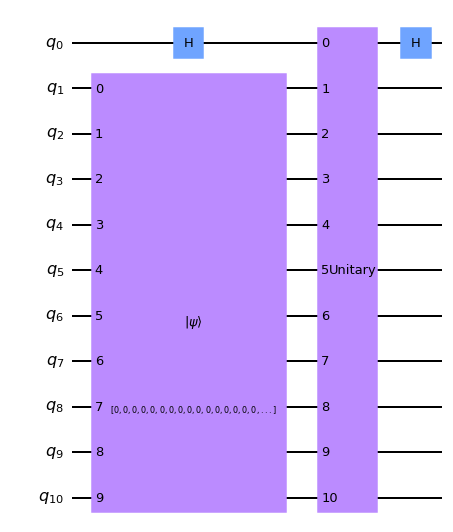

[0. 0. 0. ... 0. 0. 0.]


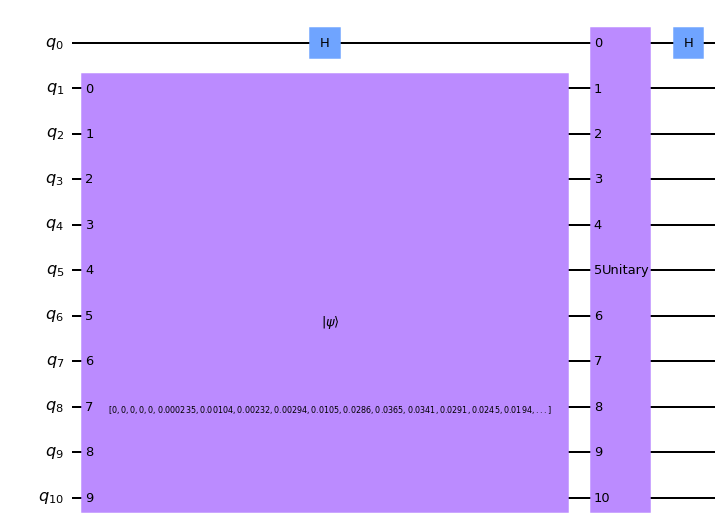

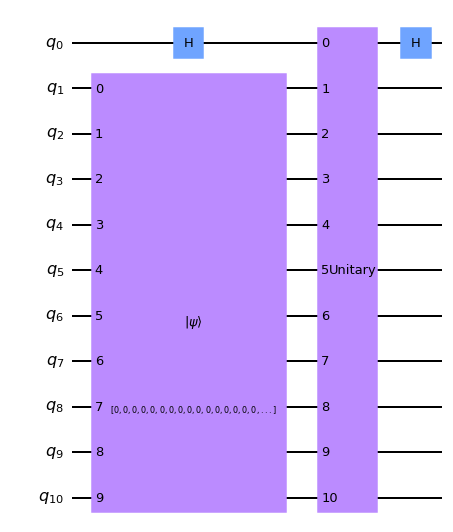

[0. 0. 0. ... 0. 0. 0.]


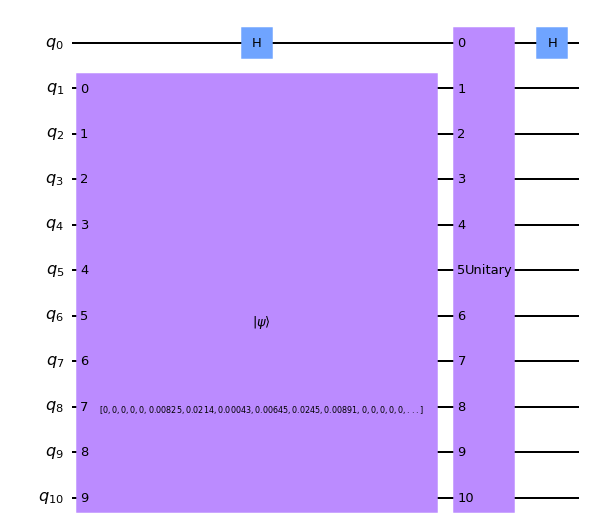

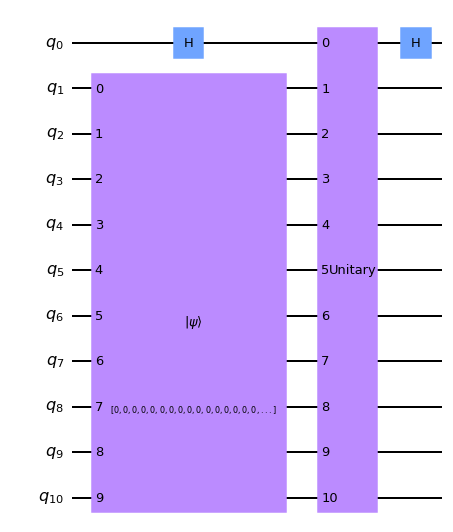

[0. 0. 0. ... 0. 0. 0.]


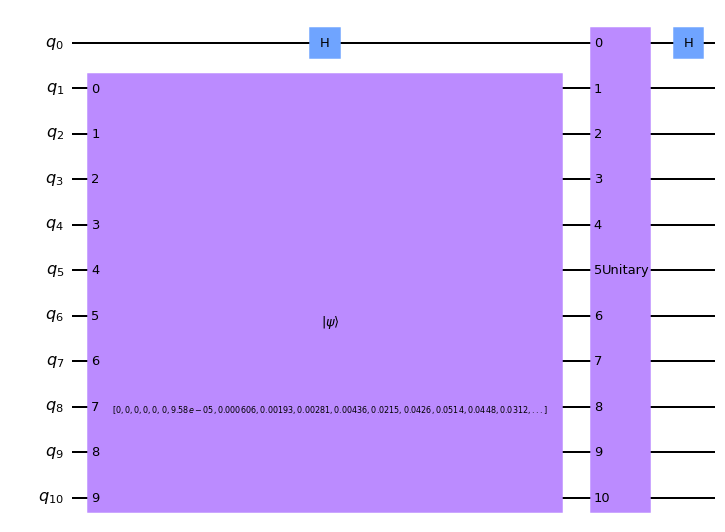

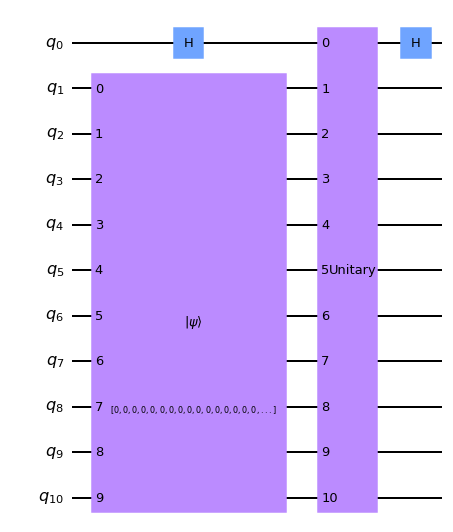

[0. 0. 0. ... 0. 0. 0.]


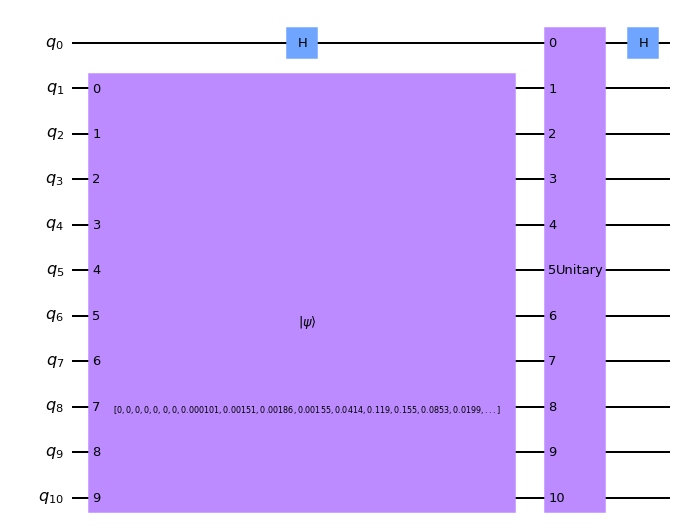

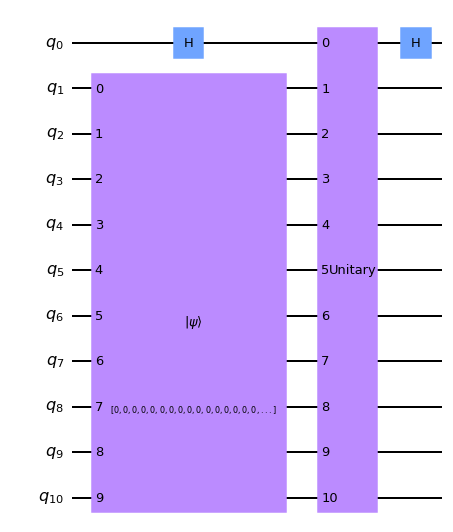

[0. 0. 0. ... 0. 0. 0.]


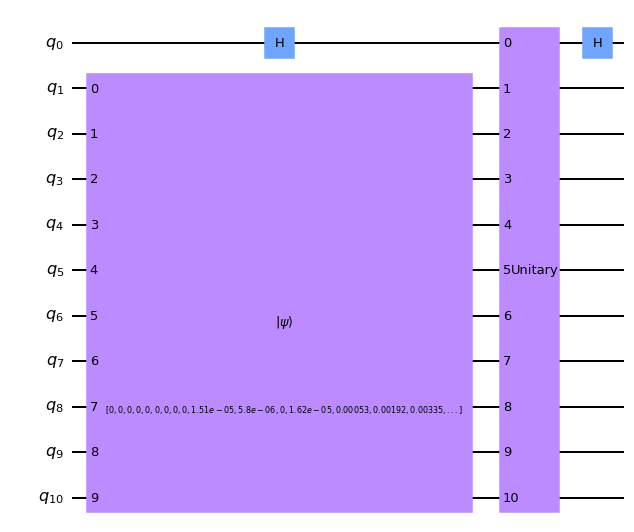

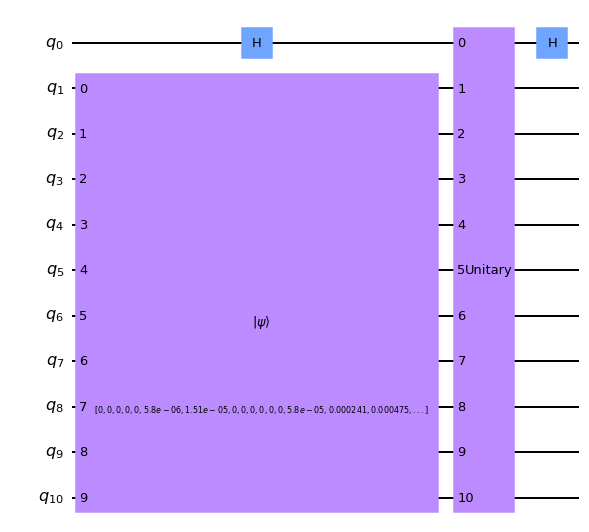

[0. 0. 0. ... 0. 0. 0.]


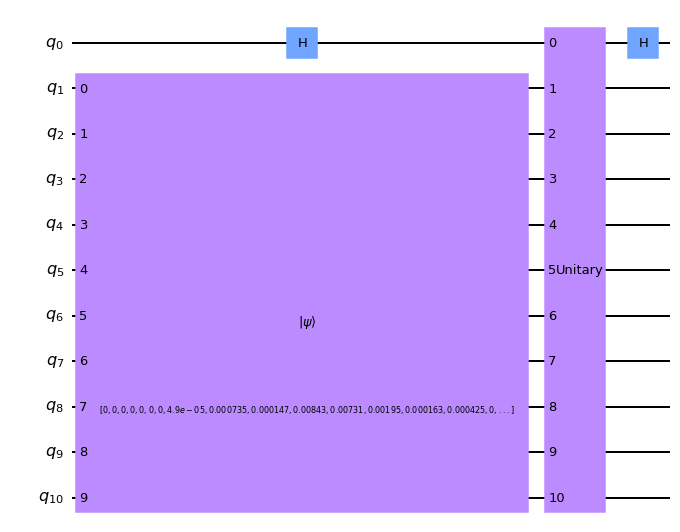

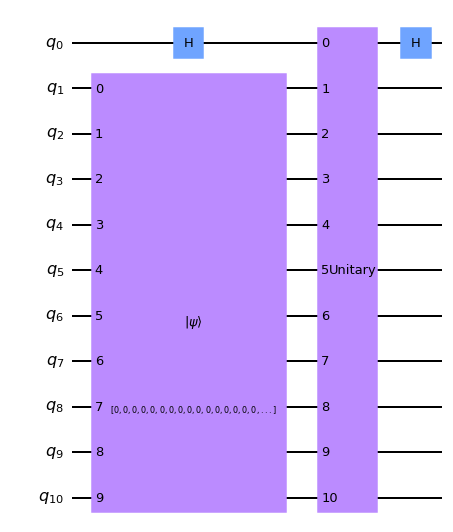

[0. 0. 0. ... 0. 0. 0.]


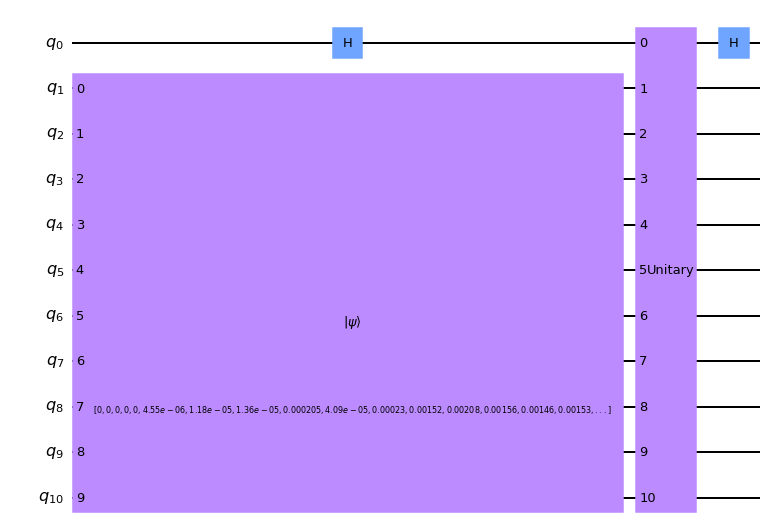

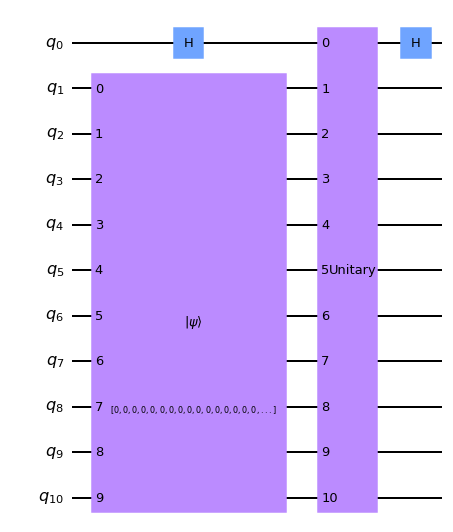

[0. 0. 0. ... 0. 0. 0.]


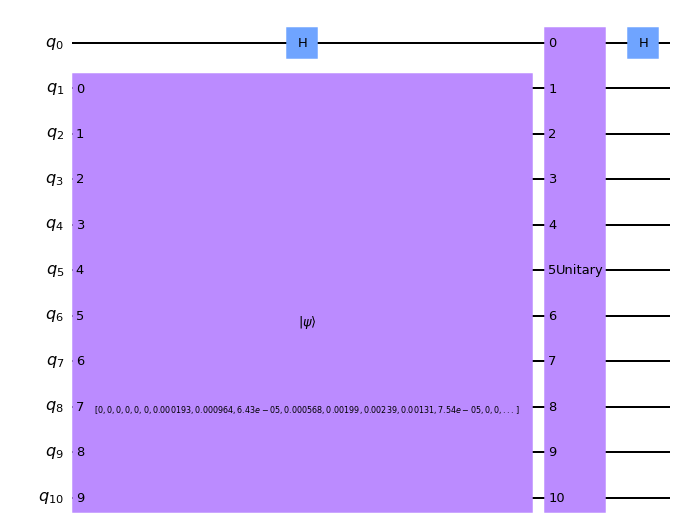

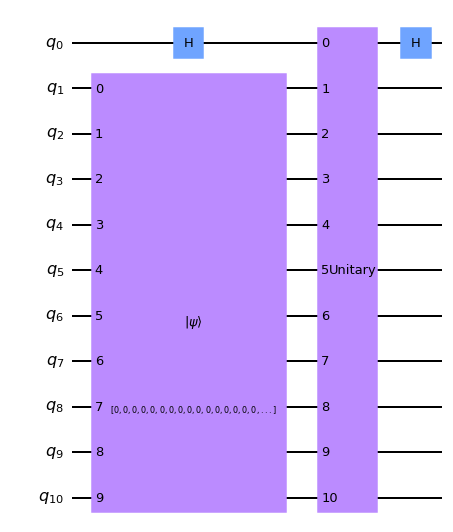

[0. 0. 0. ... 0. 0. 0.]


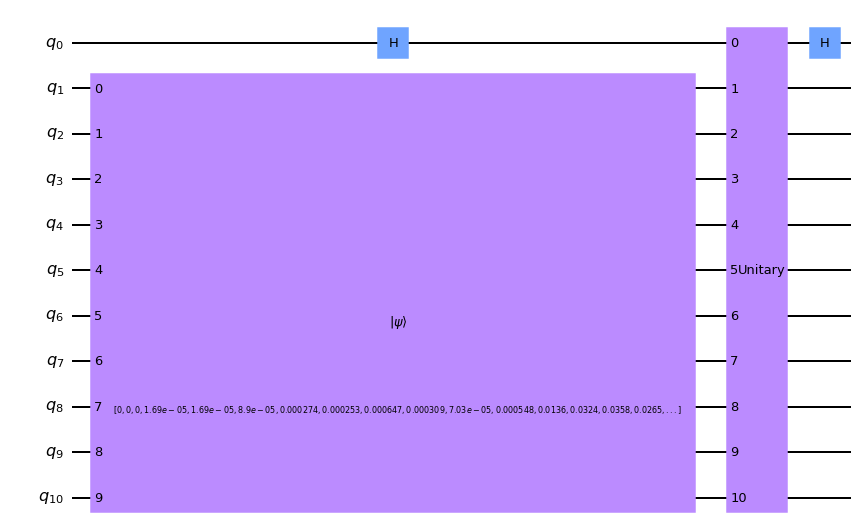

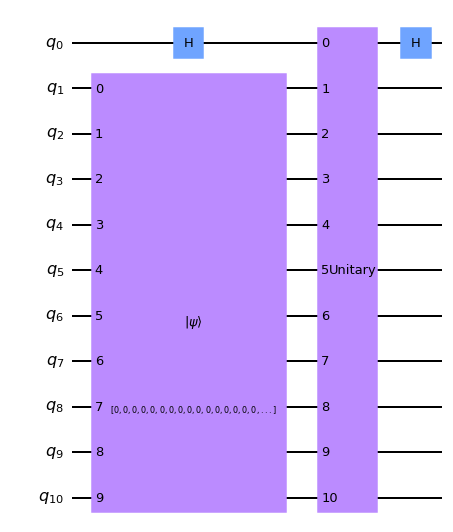

[0. 0. 0. ... 0. 0. 0.]


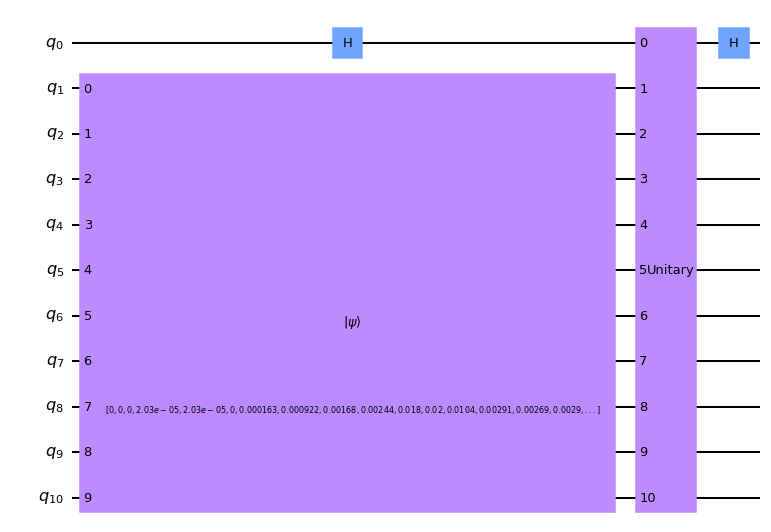

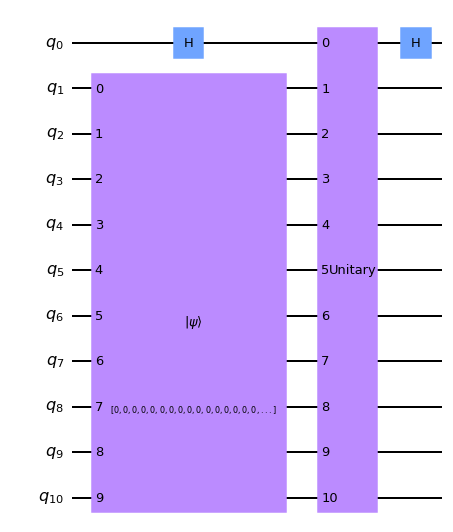

[0. 0. 0. ... 0. 0. 0.]


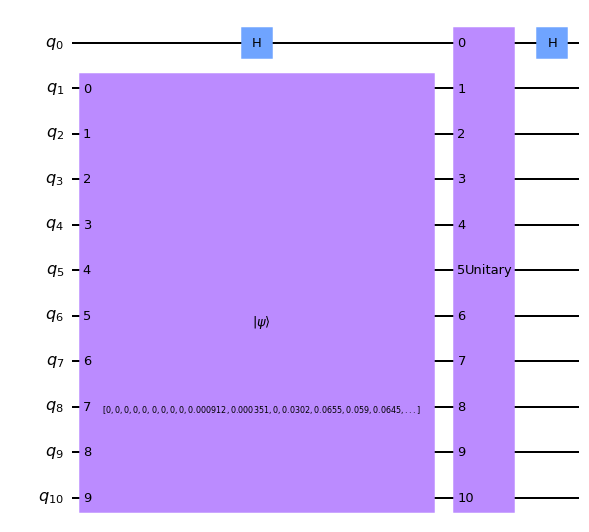

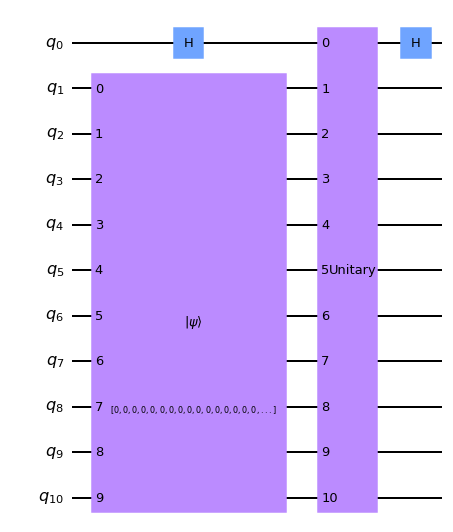

[0. 0. 0. ... 0. 0. 0.]


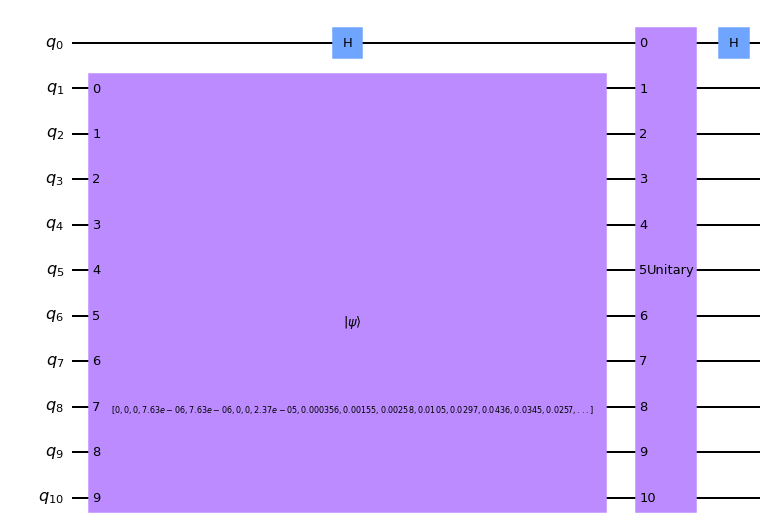

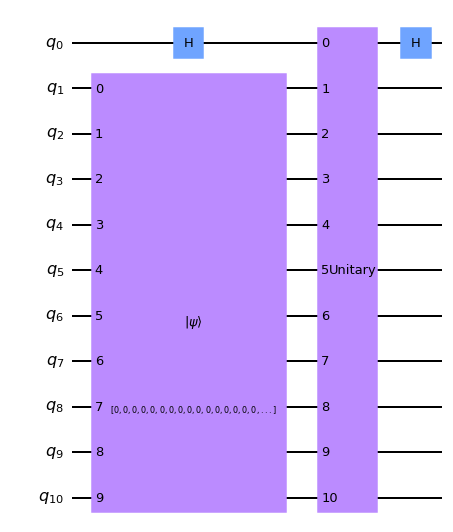

[0. 0. 0. ... 0. 0. 0.]


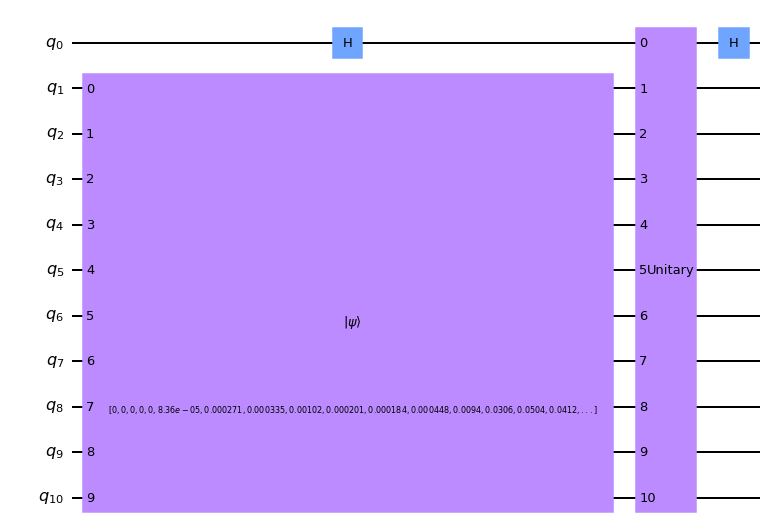

In [ ]:
#how we grade your submission

n=len(images)
mse=0
gatecount=0

for data in images:
    #encode image into circuit
    circuit,image_re=run_part1(data)
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data,image_re)
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

In [ ]:
print(f*(0.999**gatecount))